<!-- meta data for latex export -->
\setcounter{page}{0}
\title{Fixed Income Derivatives \\ Final Exam}
\author{Exam number: 12}
\date{January 18, 2025}
\maketitle
\setcounter{secnumdepth}{0}

In [1]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm

# import own module
import fixed_income_derivatives_E2024 as fid
import plotting as plot

In [2]:
alpha_caplet = 0.5
N_caplet = 21
T_caplet = np.array([i*alpha_caplet for i in range(0,N_caplet)])
strike_caplet_market = 0.055
price_caplet_market = np.array([0, 0, 3.592, 19.2679, 32.1887, 37.2136, 36.475, 32.2678, 26.9031, 21.2176, 16.2022, 12.0628,
8.8952, 6.5191, 4.8435, 3.6485, 2.8098, 2.2067, 1.7814, 1.4707, 1.2443])
price_caplet_market = price_caplet_market/10000
K_swaption_offset = np.array([-300,-250,-200,-150,-100,-50,0,50,100,150,200,250,300])
iv_swaption_market = np.array([0.220675, 0.18331, 0.155103, 0.129001, 0.10812, 0.084411, 0.071866, 0.066535, 0.073942, 0.082751, 0.093605, 0.098971, 0.108909])
EURIBOR_fixing = [{"id": 0,"instrument": "libor","maturity": 1/2, "rate":0.03772}]
fra_market = [{"id": 1,"instrument": "fra","exercise": 1/12,"maturity": 7/12, "rate": 0.04026},
{"id": 2,"instrument": "fra","exercise": 2/12,"maturity": 8/12, "rate": 0.04261},
{"id": 3,"instrument": "fra","exercise": 3/12,"maturity": 9/12, "rate": 0.04477},
{"id": 4,"instrument": "fra","exercise": 4/12,"maturity": 10/12, "rate": 0.04677},
{"id": 5,"instrument": "fra","exercise": 5/12,"maturity": 11/12, "rate": 0.0486},
{"id": 6,"instrument": "fra","exercise": 6/12,"maturity": 12/12, "rate": 0.05029},
{"id": 7,"instrument": "fra","exercise": 7/12,"maturity": 13/12, "rate": 0.05183},
{"id": 8,"instrument": "fra","exercise": 8/12,"maturity": 14/12, "rate": 0.05324},
{"id": 9,"instrument": "fra","exercise": 9/12,"maturity": 15/12, "rate": 0.05452}]
swap_market = [{"id": 10,"instrument": "swap","maturity": 2, "rate": 0.05228, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 11,"instrument": "swap","maturity": 3, "rate": 0.05602, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 12,"instrument": "swap","maturity": 4, "rate": 0.05755, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 13,"instrument": "swap","maturity": 5, "rate": 0.05791, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 14,"instrument": "swap","maturity": 7, "rate": 0.05718, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 15,"instrument": "swap","maturity": 10, "rate": 0.05539, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 16,"instrument": "swap","maturity": 15, "rate": 0.05324, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 17,"instrument": "swap","maturity": 20, "rate": 0.05205, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 18,"instrument": "swap","maturity": 30, "rate": 0.05087, "float_freq": "semiannual", "fixed_freq": "annual","indices": []}]
data_zcb = EURIBOR_fixing + fra_market + swap_market

## Problem 1

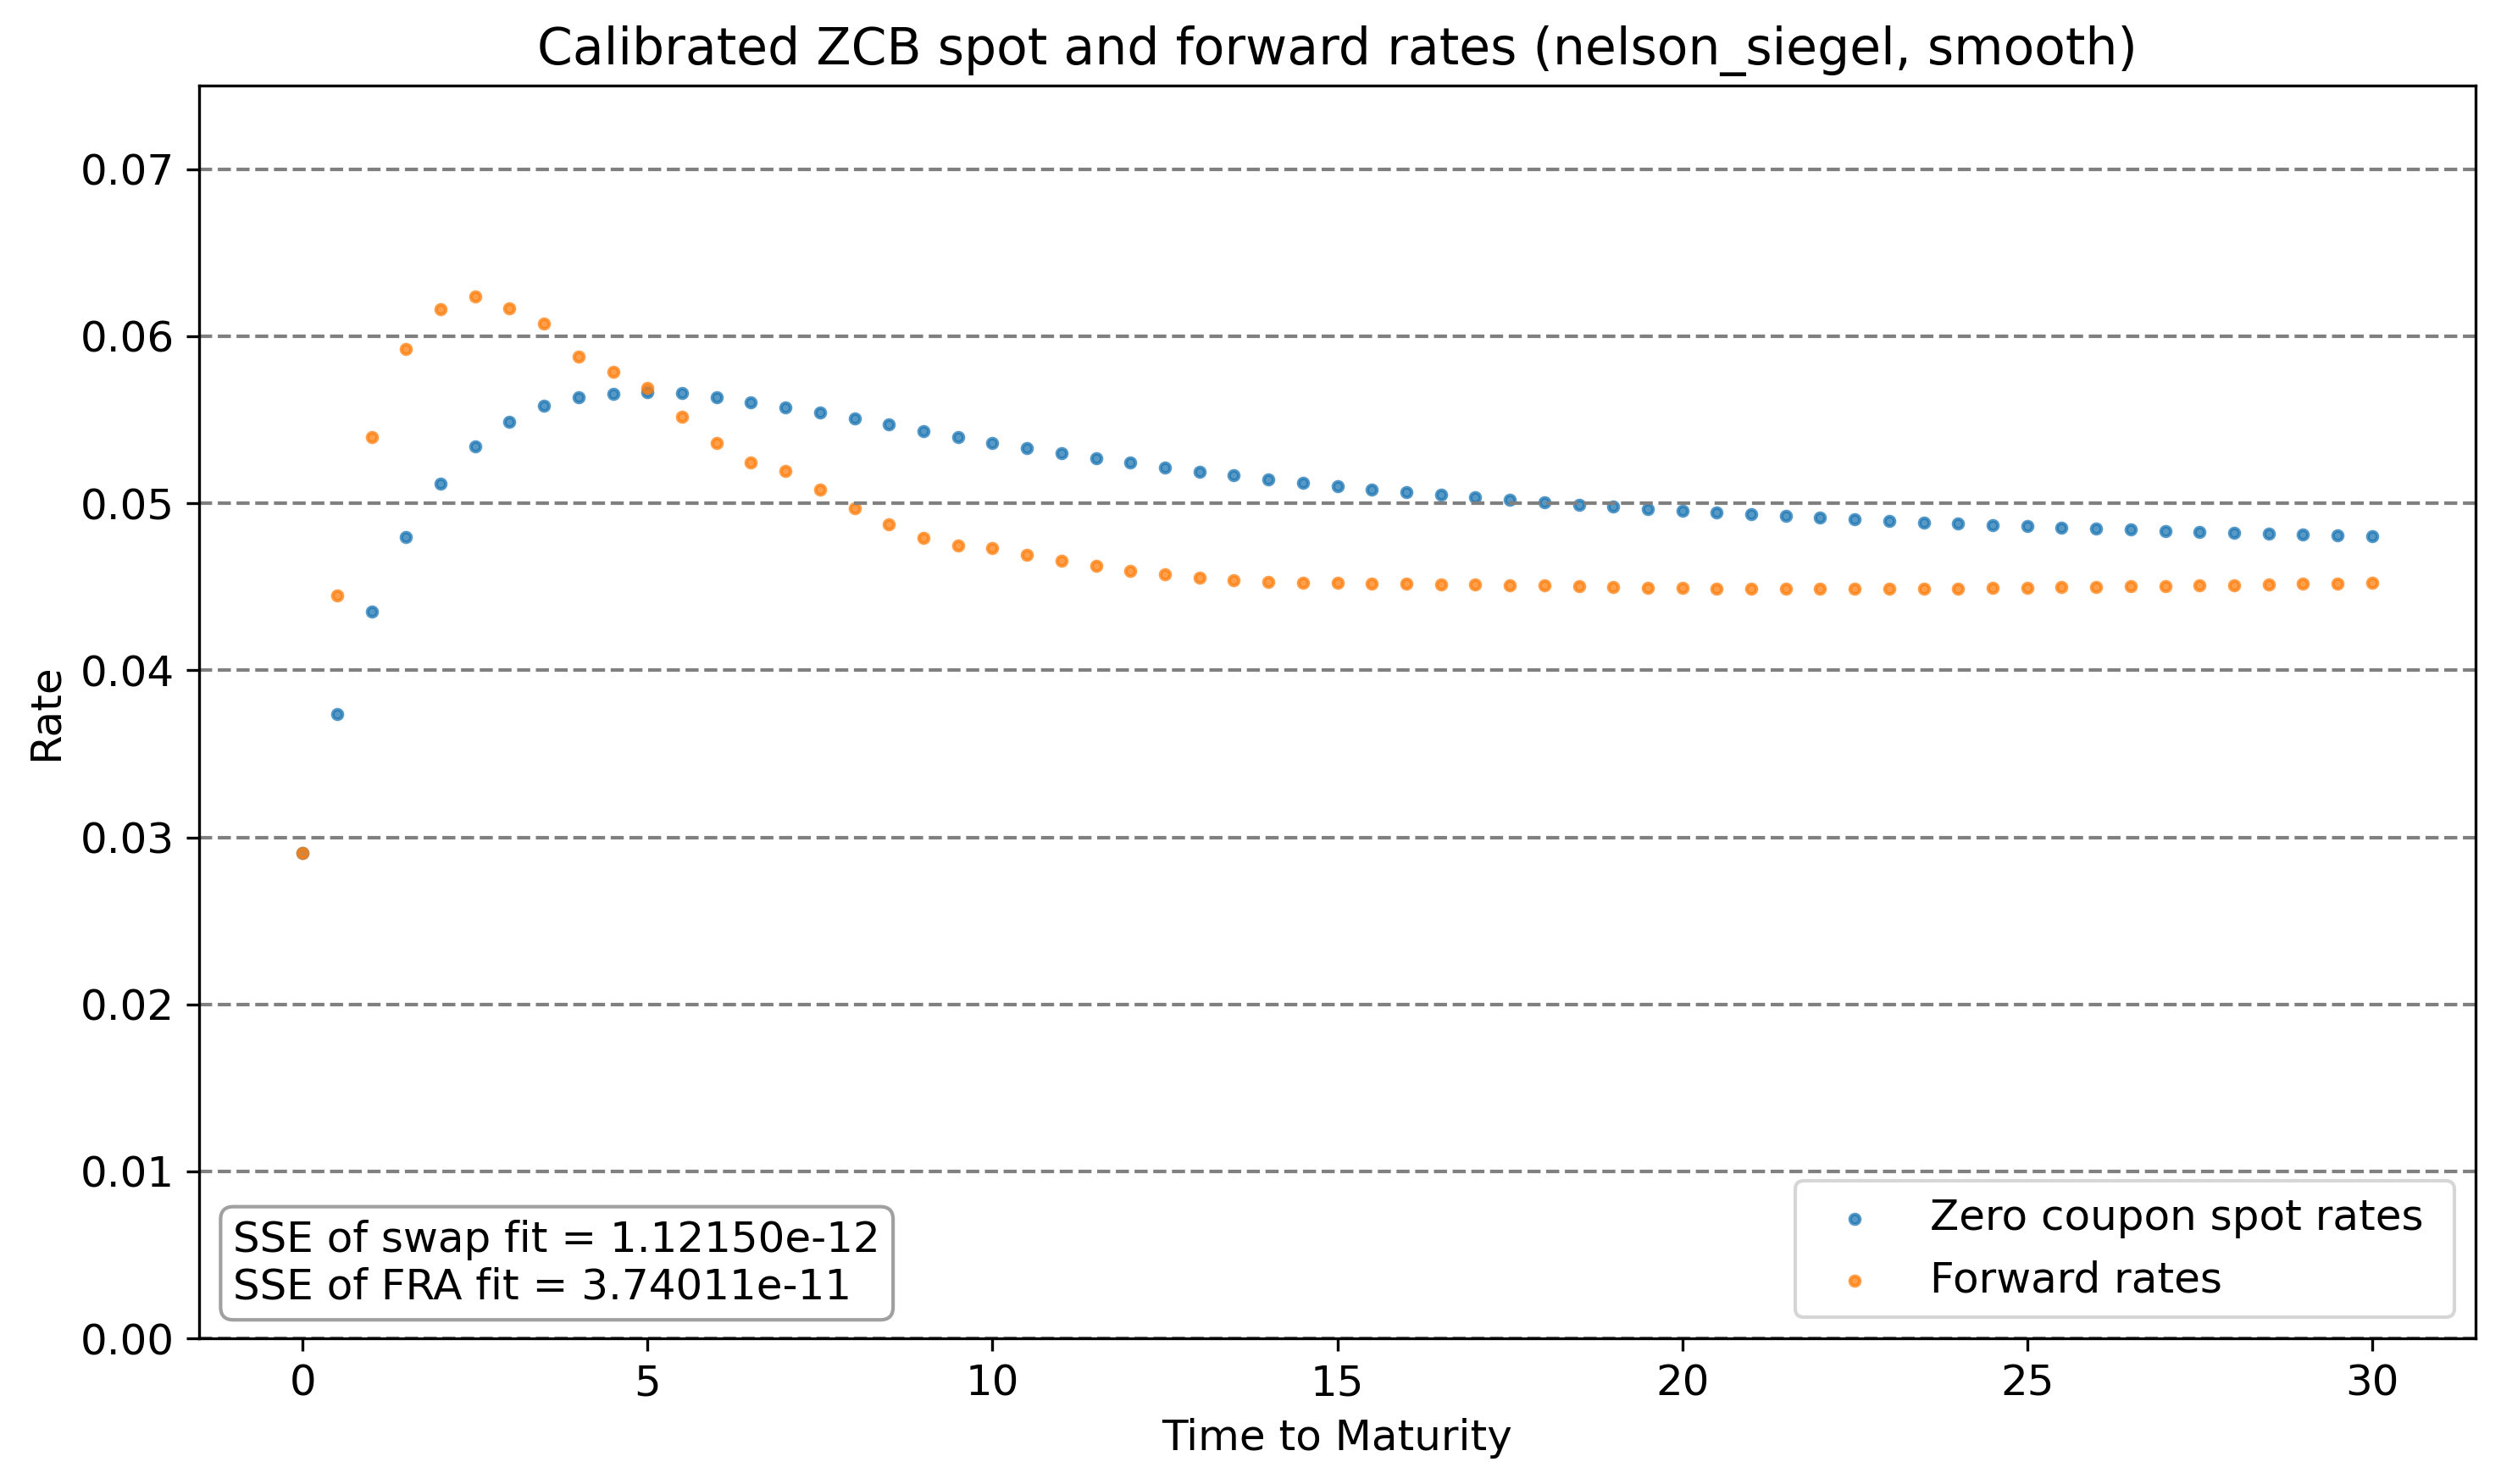

Zero coupon spot rates for selected maturities:
0.5:  0.03737
1.0:  0.04352
2.0:  0.05115
3.0:  0.05485
5.0:  0.05666
10.0:  0.05361
15.0:  0.05101
20.0:  0.04955
30.0:  0.04803


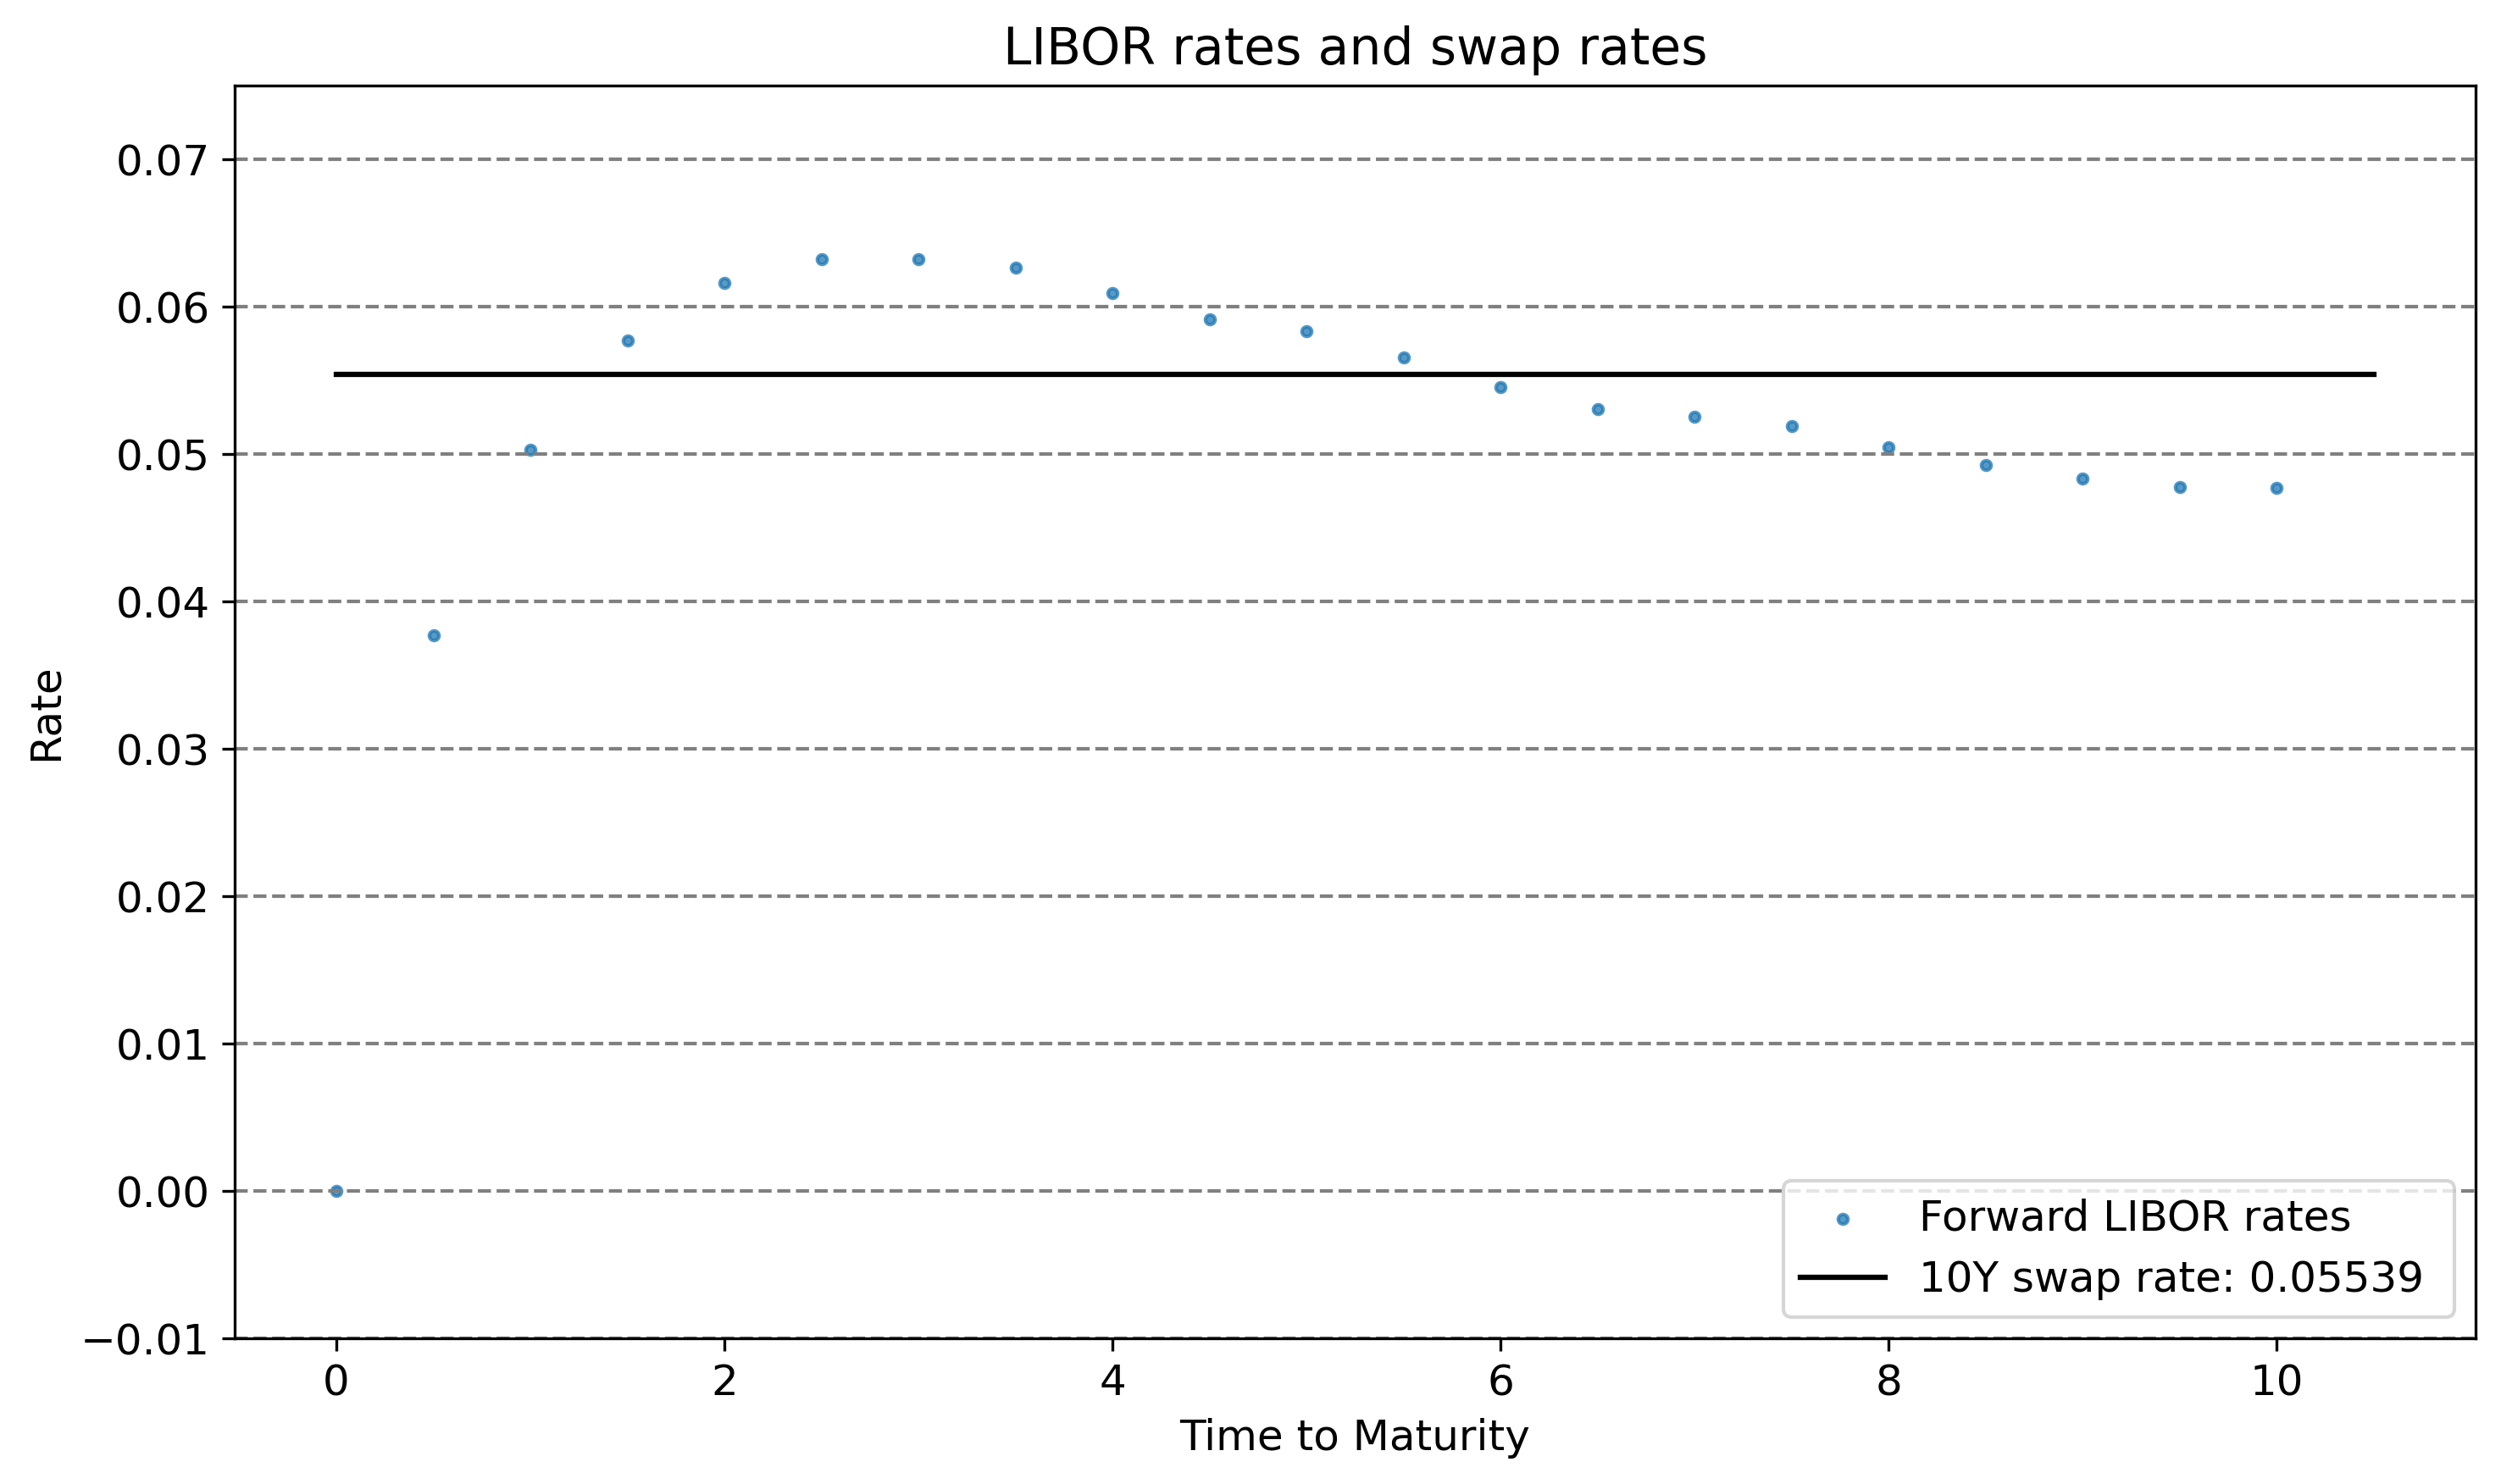

In [3]:
# a
interpolation_options = {"method":"nelson_siegel","transition": 'smooth'}
T_fit, R_fit, sse = fid.zcb_curve_fit(data_zcb,interpolation_options=interpolation_options)
T_inter = np.linspace(0, 30, 2*int(T_fit[-1])+1)
p_inter, R_inter, f_inter, T_inter = fid.zcb_curve_interpolate(T_inter=T_inter, T=T_fit, R=R_fit, interpolation_options=interpolation_options)
fit = [{'label':'Zero coupon spot rates', 'x':T_inter, 'y':R_inter,'s':30},
       {'label':'Forward rates', 'x':T_inter, 'y':f_inter,'s':30}]
text = {'SSE of swap fit':f'{sse[0]:.5e}', 'SSE of FRA fit':f'{sse[1]:.5e}'}
plot.rates(fit,title=f'Calibrated ZCB spot and forward rates ({interpolation_options["method"]}, {interpolation_options["transition"]})',text=text)
T_report = np.array([0.5, 1, 2, 3, 5, 10, 15, 20, 30])
R_report = np.zeros(len(T_report))
print('Zero coupon spot rates for selected maturities:')
for i, t in enumerate(T_report):
    R_report[i] = fid.find_value_return_value(t, T_inter, R_inter, precision=1e-8)[1][0][1]
    print(f'{T_report[i]:.1f}:  {R_report[i]:.5f}')
# c
R_swap, S_swap = fid.swap_rate_from_zcb_prices(0,0,10,'annual',T_inter,p_inter,float_freq='semiannual')
L = fid.forward_libor_rates_from_zcb_prices(T_inter,p_inter)
libor_plot = [{'label':'Forward LIBOR rates', 'x':T_inter[:21], 'y':L[:21],'s':30},
              {'label':f'10Y swap rate: {R_swap:.5f}', 'x':np.array([0,T_inter[21]]), 'y':R_swap*np.ones(2),'type':'line','color':'black'}]
plot.rates(libor_plot,title='LIBOR rates and swap rates')

#### a)
When I fit the ZCB curve to the swap and forward rate agreement data I find it fits the data well. To get the SSE of the fit I modify the `fixed_income_derivatives_E2024.py` file, specifically the `zcb_curve_fit` function to get it to include in the returned values. Looking at those I find the SSE of the swap fit to be $1.2\cdot 10^{-12}$ and the following FRA fit results in an SSE of $3.7\cdot 10^{-11}$ hence the fitted curves does fit the market data well. The continously compounded zero coupon spot rates for the selected maturities are as follows:

$$
\begin{array}{|c|c|c|c|c|c|c|c|c|}
\hline
\textbf{0.5} & \textbf{1.0} & \textbf{2.0} & \textbf{3.0} & \textbf{5.0} & \textbf{10.0} & \textbf{15.0} & \textbf{20.0} & \textbf{30.0} \\
\hline
0.03737 & 0.04352 & 0.05115 & 0.05485 & 0.05666 & 0.05361 & 0.05101 & 0.04955 & 0.04803 \\
\hline
\end{array}
$$

#### b)
Ideally the fitted instantaneous forward rates should be continuous to prevent that interest rate derivatives with nearly the same maturity can have vastly different prices. This happens only if the zero coupon bond prices are differentiable. I have choosen the implemented Nelson-Siegel function as it generally is good at fitting smooth curves compared to e.g. the linear interpolation and does not go crazy towards the end as higher degree Hermite polynomails tend to.

#### c) 
The 10Y par swap rate I have calculated is $0.05539$, equivalent to the 10Y par swap rate given in the swap market data. This par swap rate represents a weighted average of forward EURIBOR rates at issuance, with greater weight placed on near-term forward rates. This allows investors to use swaps to manage or hedge interest rate risk while mitigating credit risk

## Problem 2

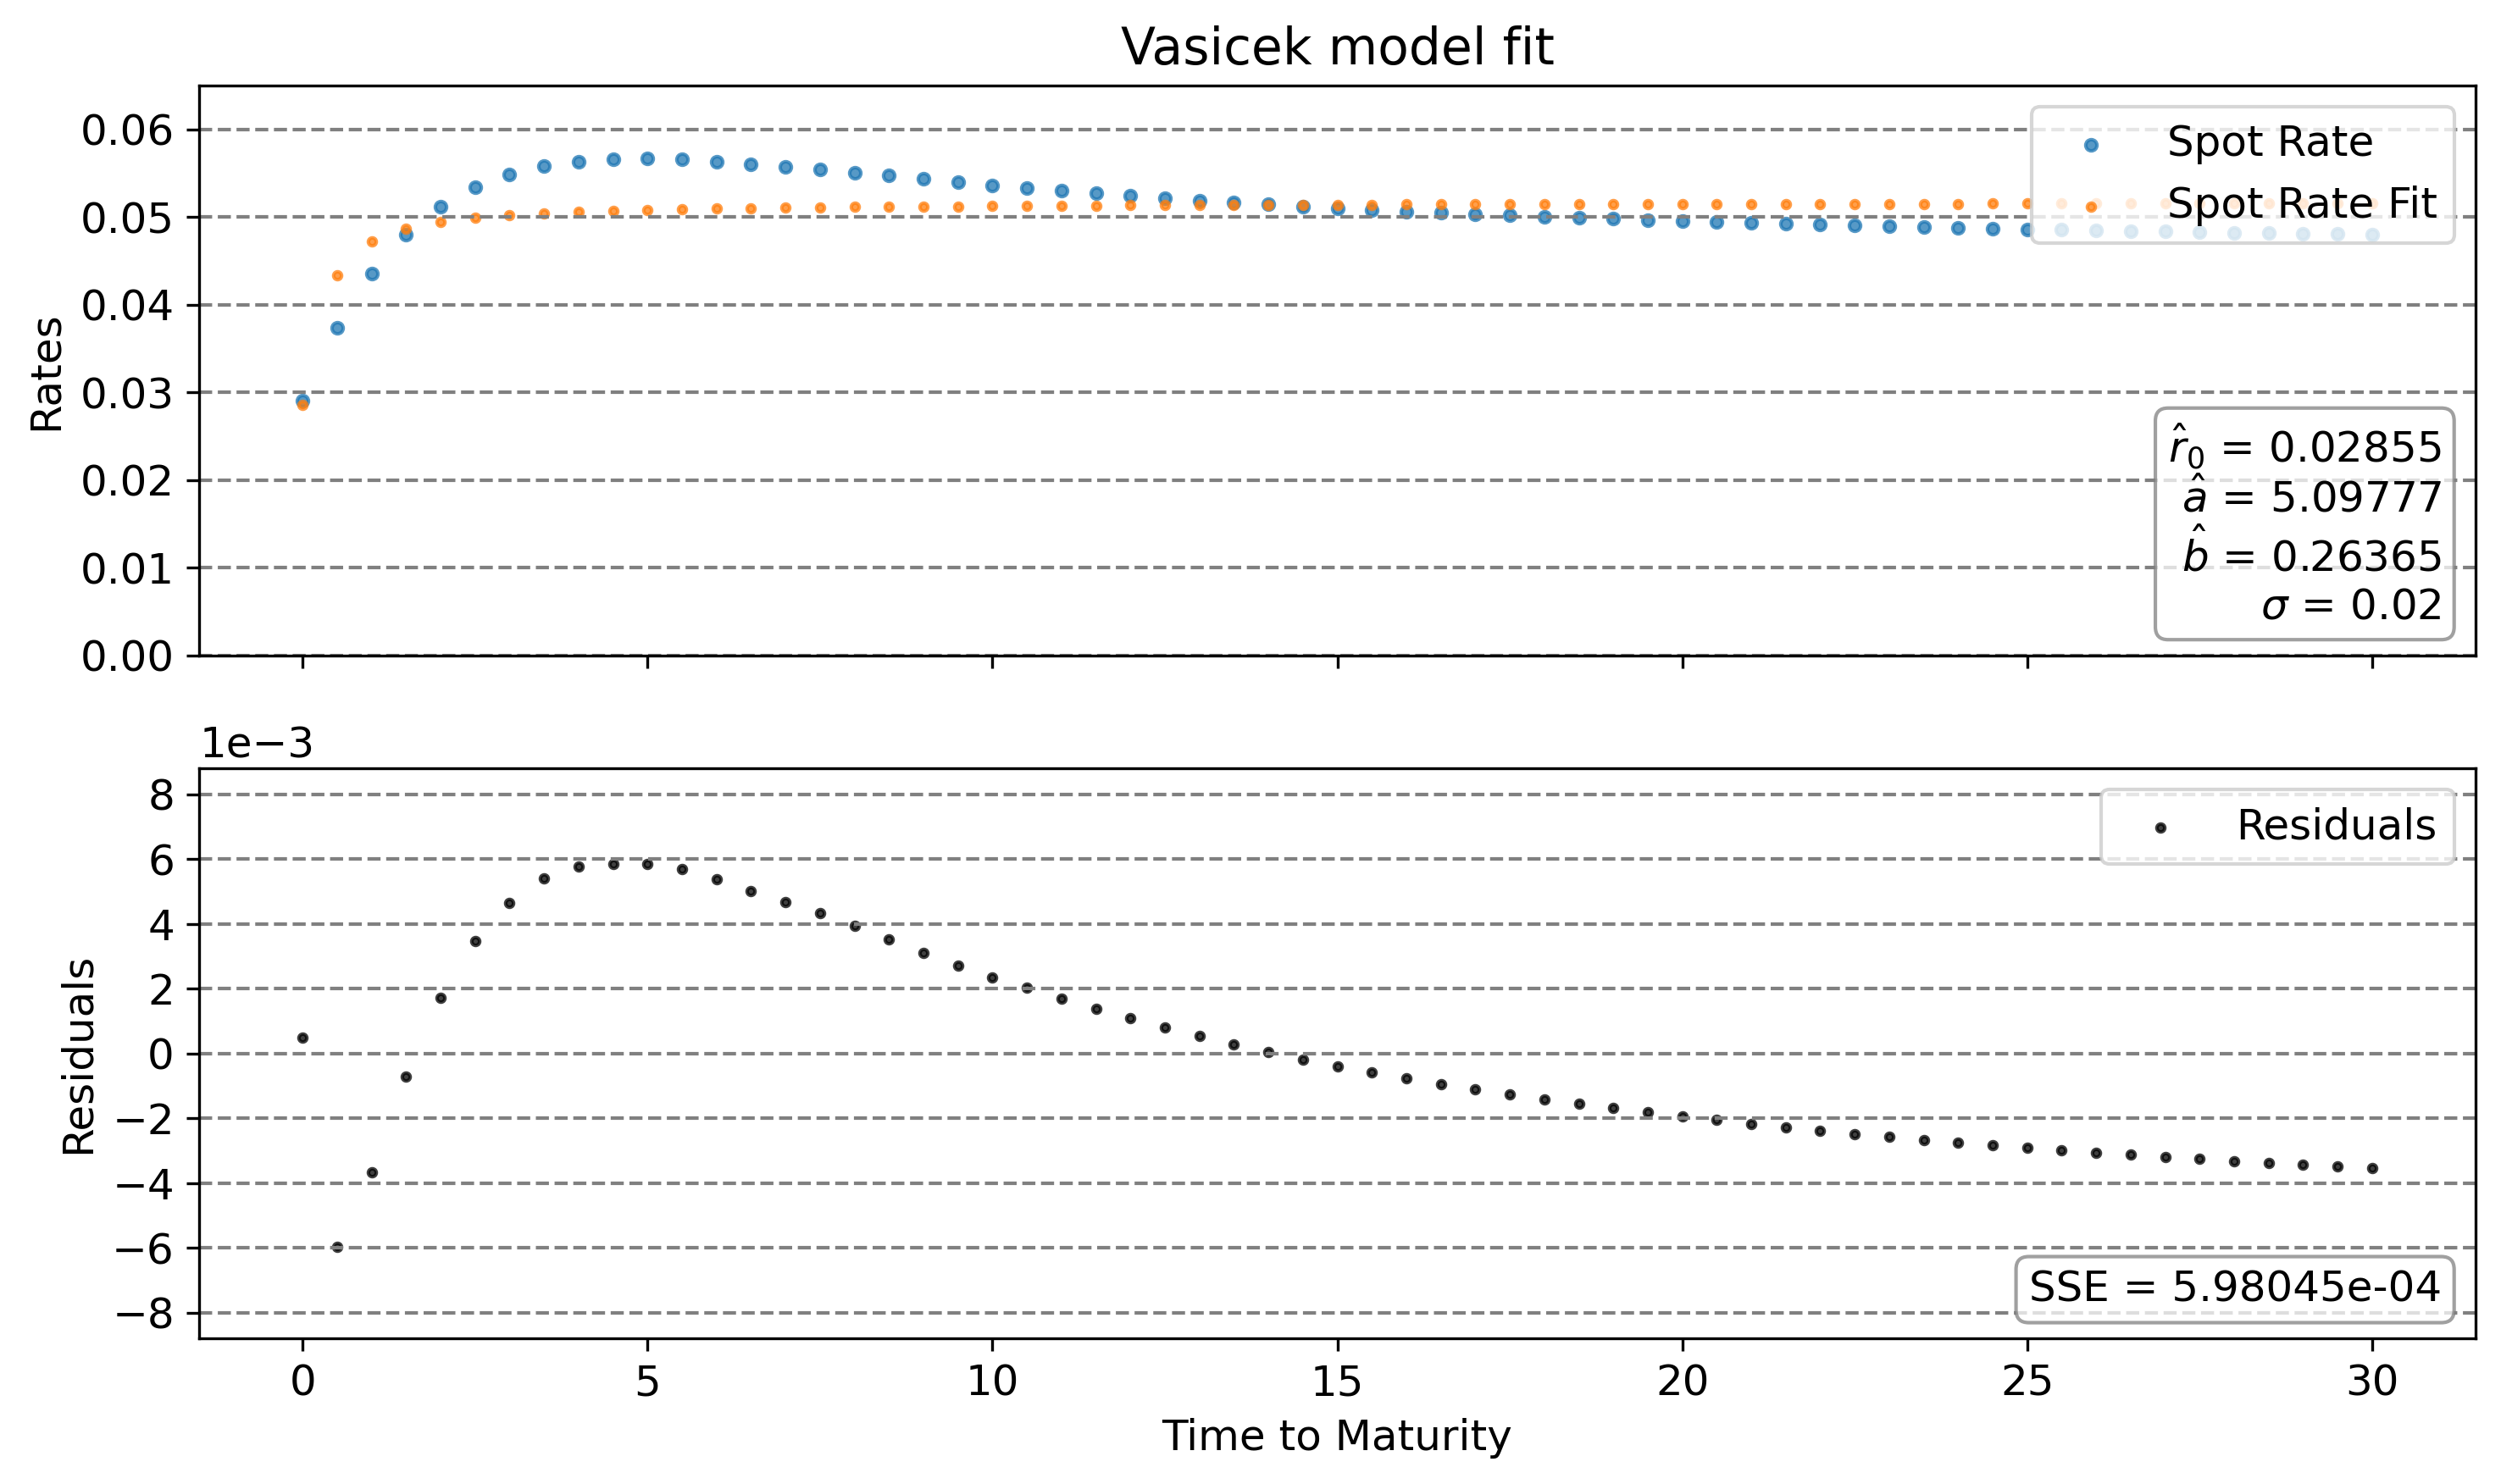

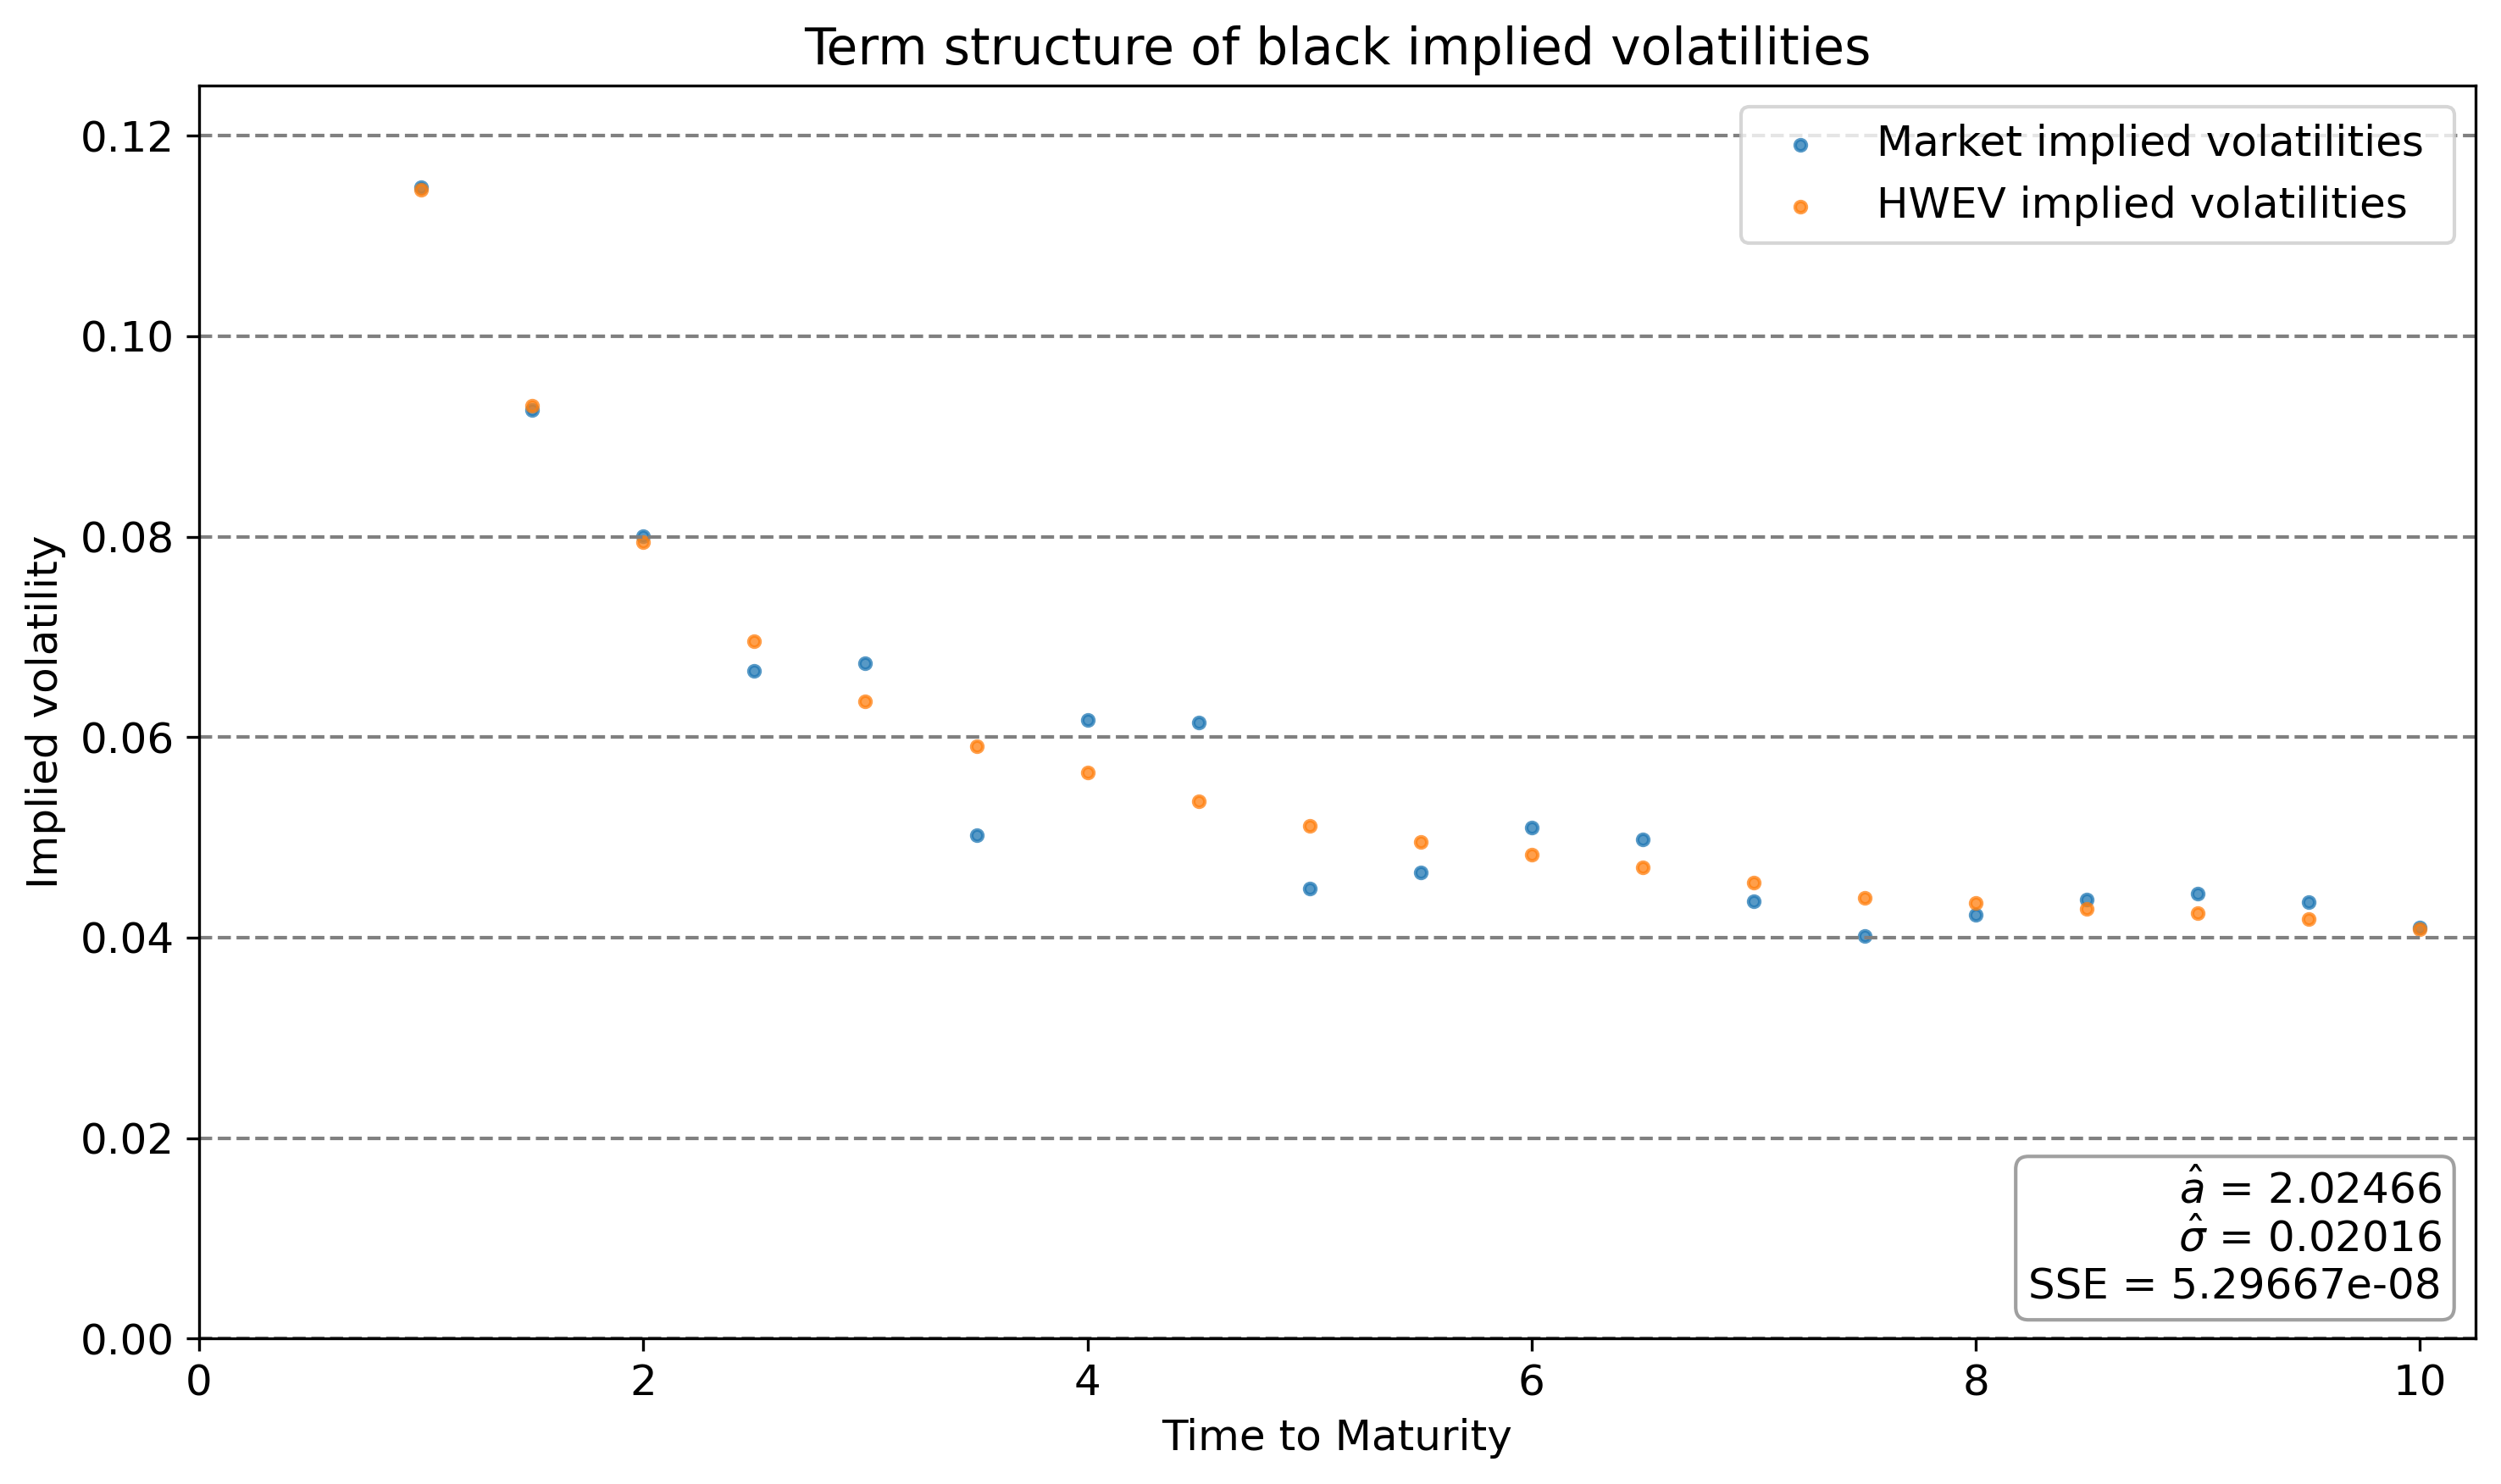

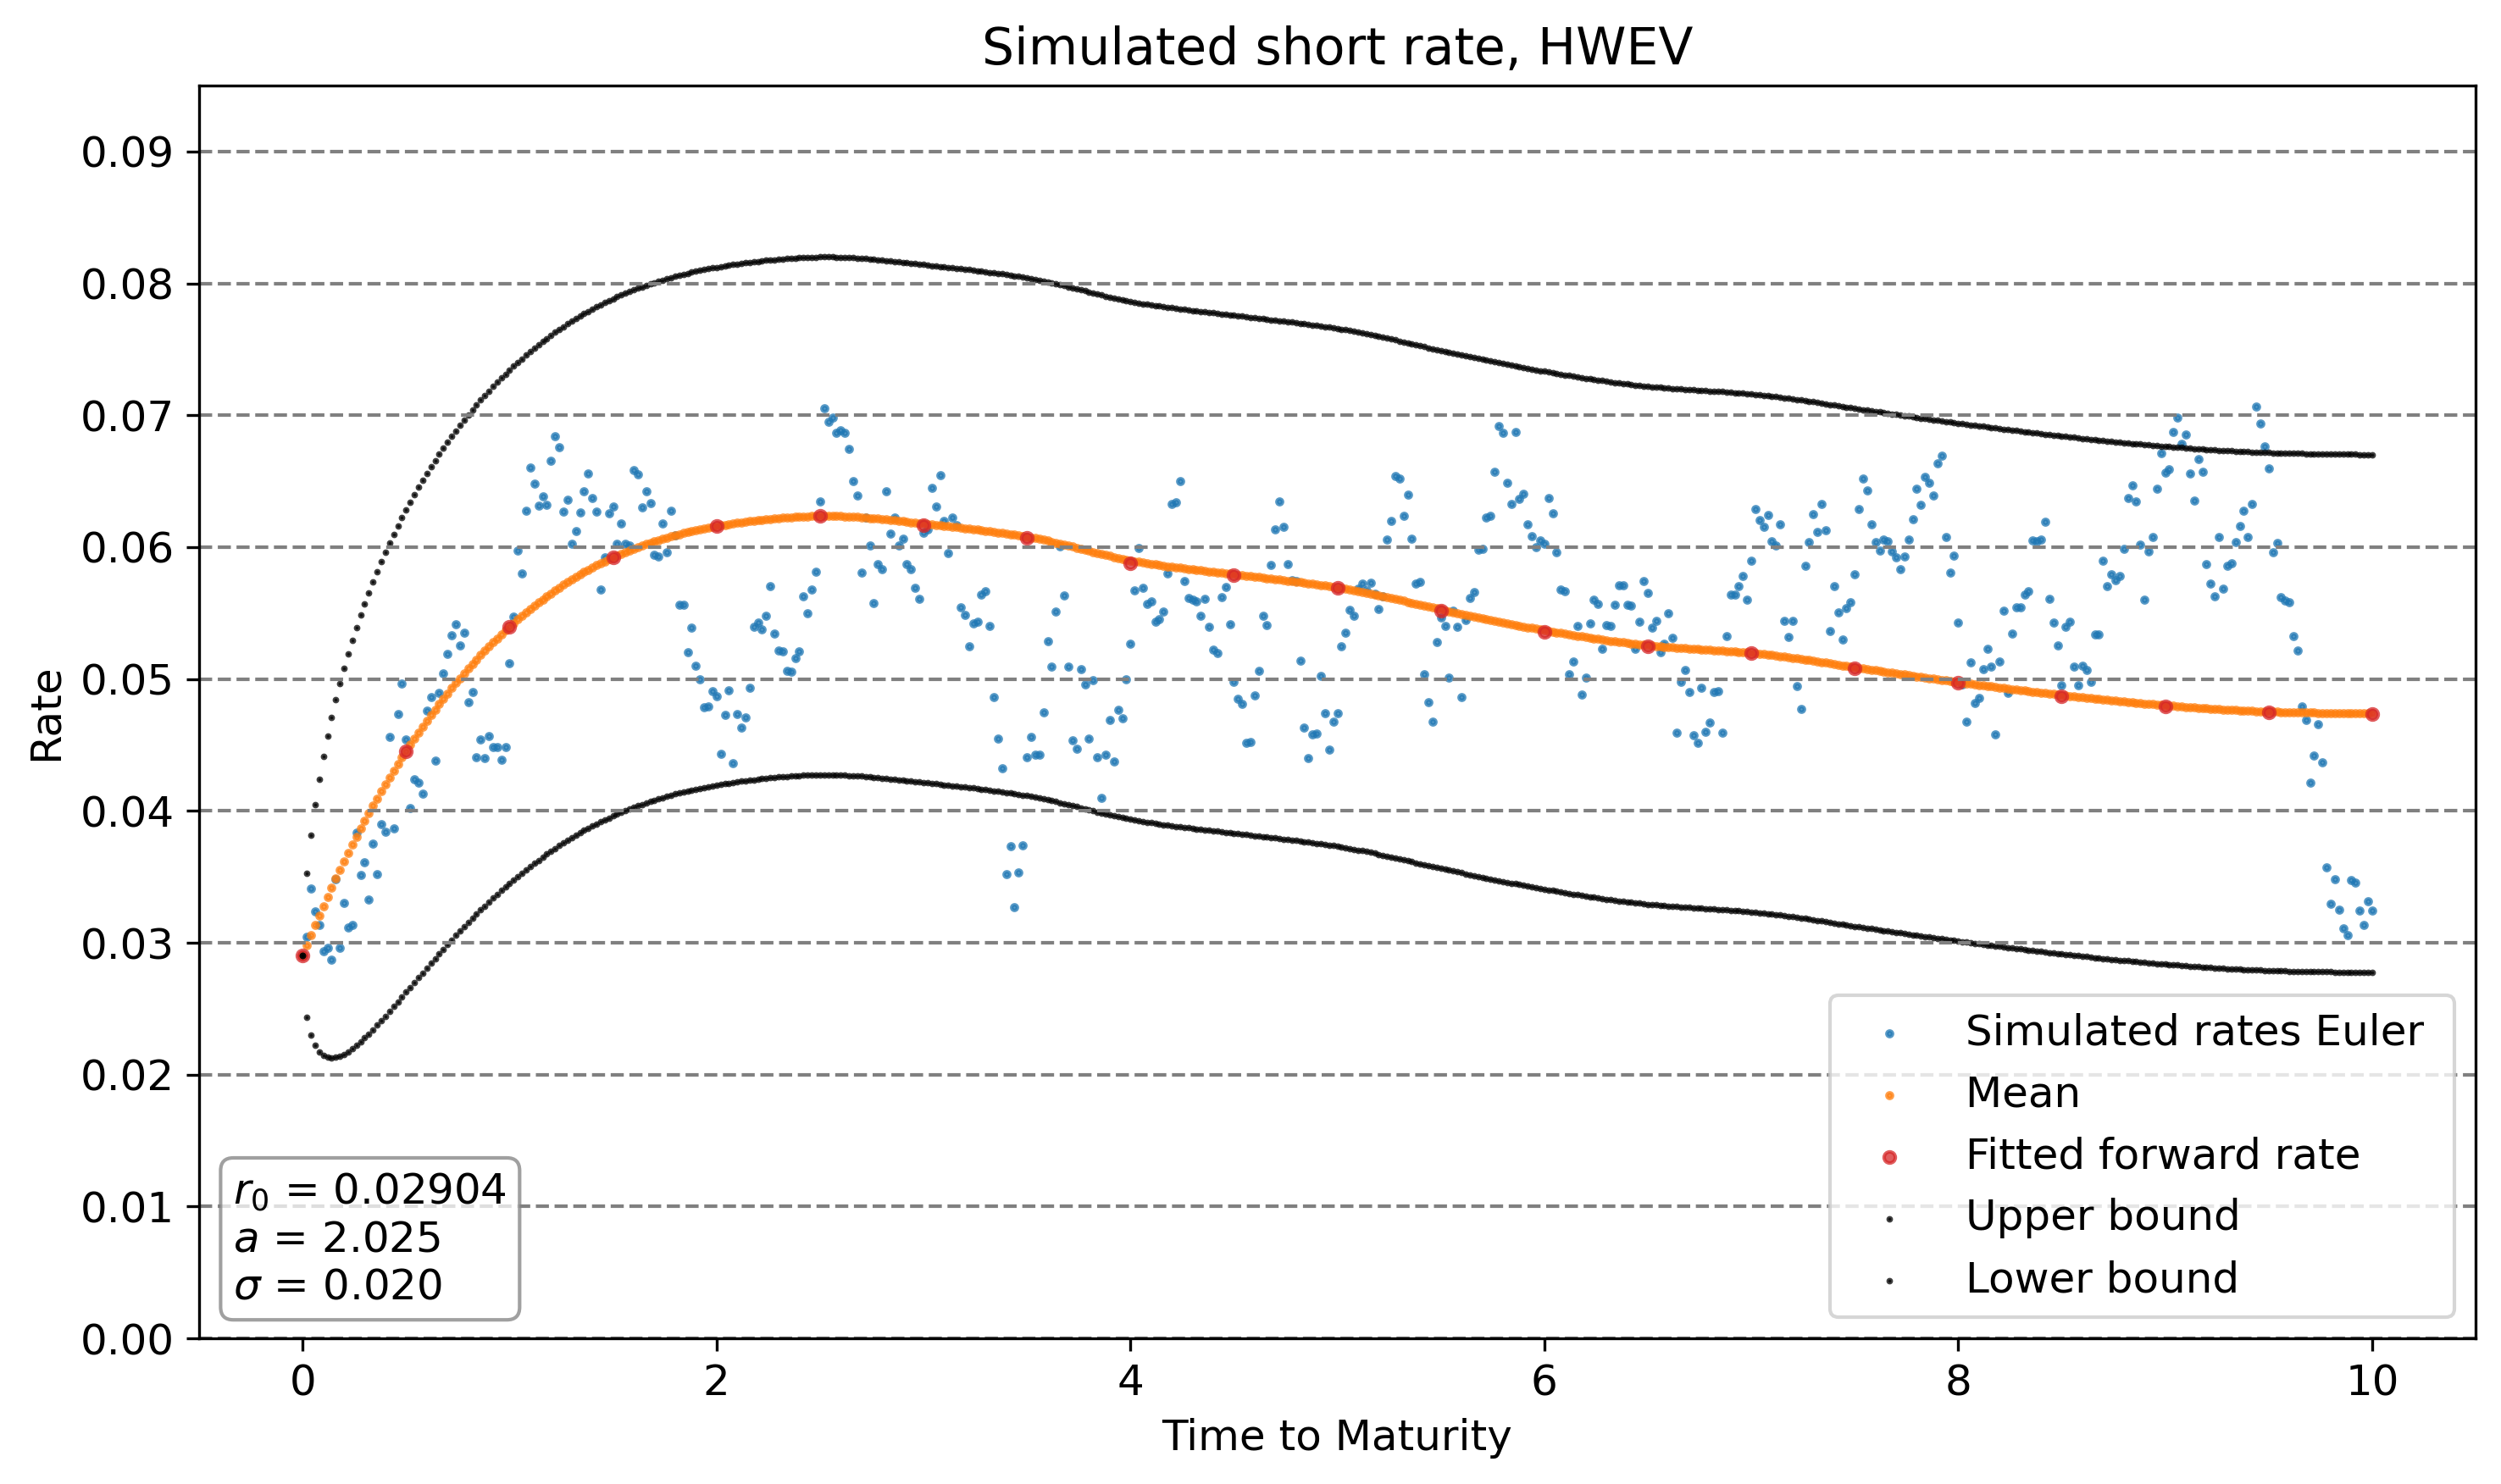

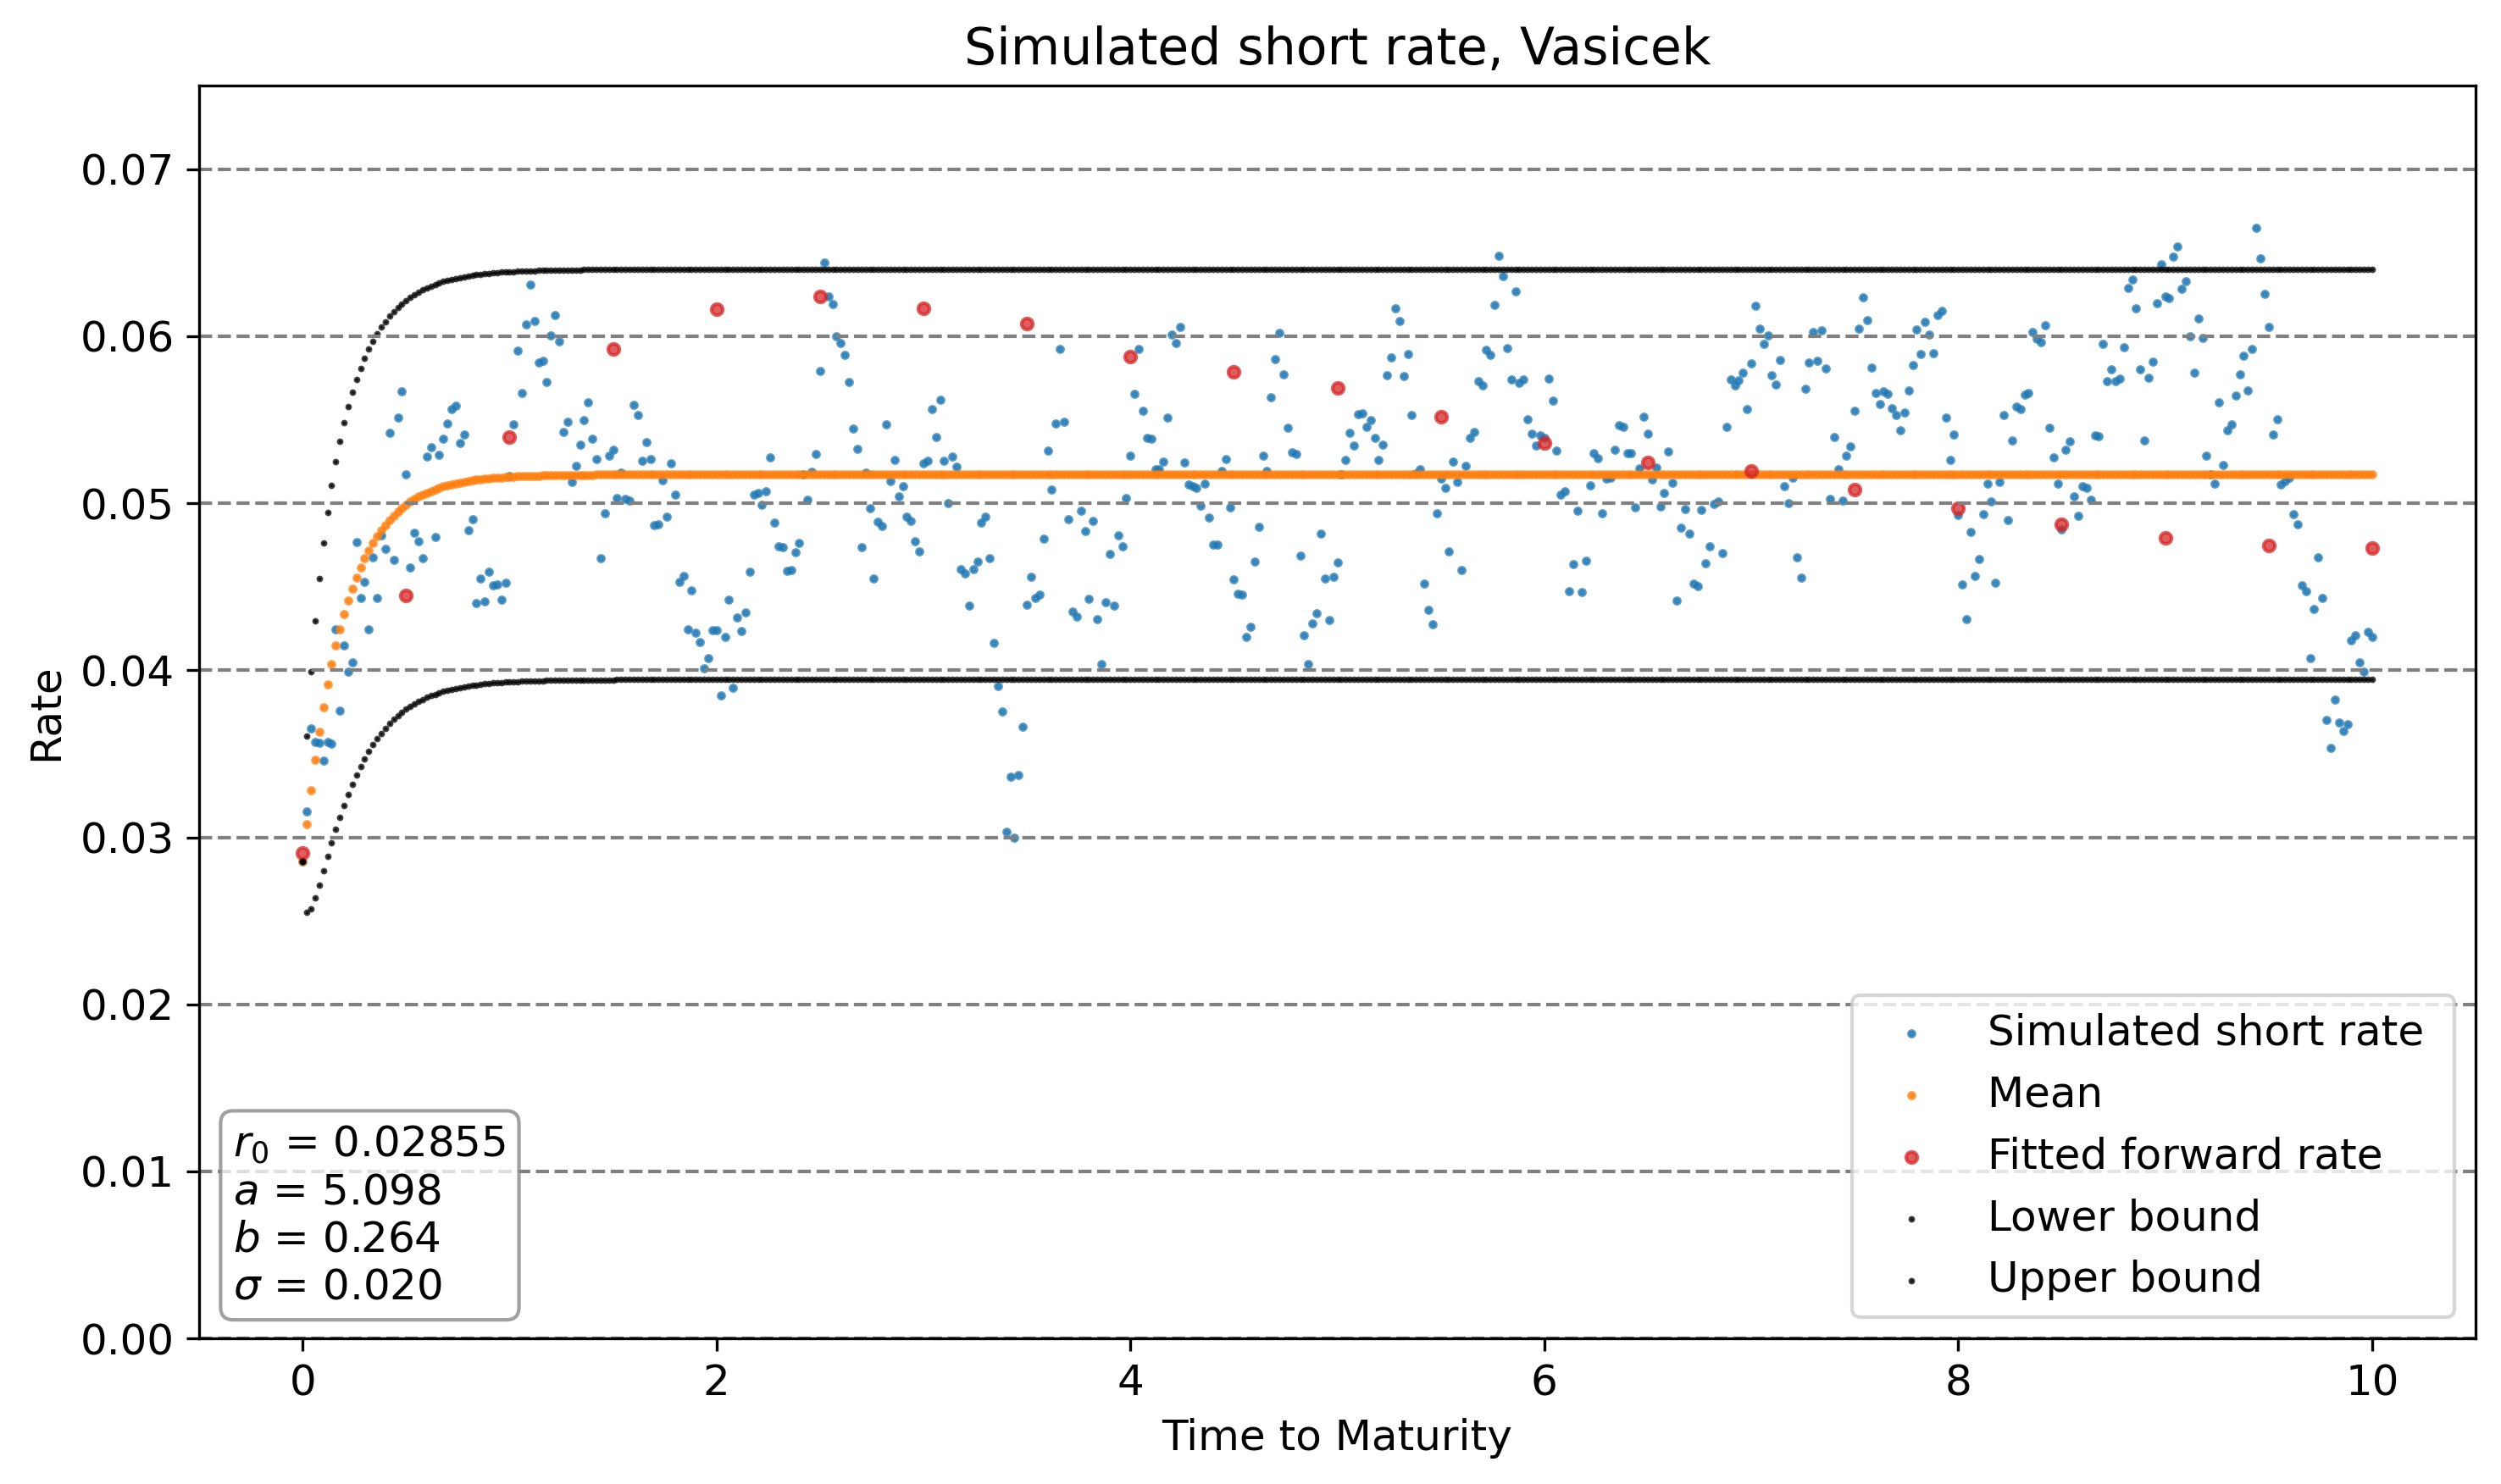

Caplet prices for selected maturities:
1.0:  0.65527 bps
2.0:  15.63854 bps
4.0:  12.31170 bps
6.0:  2.56150 bps
8.0:  0.65319 bps
10.0:  0.20938 bps
upfront cost of cap: 120.06755 bps,
semi-annual premium: 7.90387 bps


In [4]:
interpolation_options = {"method":"nelson_siegel","transition": 'smooth'}
T_fit, R_fit, sse = fid.zcb_curve_fit(data_zcb,interpolation_options=interpolation_options)
T_inter = np.linspace(0, 30, 2*int(T_fit[-1])+1)
p_inter, R_inter, f_inter, T_inter = fid.zcb_curve_interpolate(T_inter=T_inter, T=T_fit, R=R_fit, interpolation_options=interpolation_options)
L = fid.forward_libor_rates_from_zcb_prices(T_inter[:N_caplet],p_inter[:N_caplet])
# a
sigma_vasicek = 0.02
param0 = 0.035, 6, 0.025
result = minimize(fid.fit_vasicek_no_sigma_obj, param0, args=(sigma_vasicek, R_inter, T_inter), method='nelder-mead', options={'xatol': 1e-12, 'disp': False})
r0_vasicek, a_vasicek, b_vasicek = result.x
R_fit = fid.spot_rate_vasicek(r0_vasicek,a_vasicek,b_vasicek,sigma_vasicek, T_inter)
fit = [{'label':'Spot Rate','x':T_inter,'y':R_inter,'s':40},
       {'label':'Spot Rate Fit','x':T_inter,'y':R_fit}]
res = [{'label':'Residuals','x':T_inter,'y':R_inter - R_fit}]
text = {'$\hat{r}_0$':r0_vasicek,'$\hat{a}$':a_vasicek,'$\hat{b}$':b_vasicek,'$\sigma$':f'{sigma_vasicek:.2f}'}
text_res = {'SSE':result.fun}
plot.fit(fit,res,'Vasicek model fit',text,text_res)
# b
def fit_hwev_obj(param, strike, T, p, price_caplet_market):
    a, sigma = param
    caplet_hwev = fid.caplet_prices_hwev(strike, a, sigma, T, p)
    return np.sum((caplet_hwev - price_caplet_market)**2)
param0 = 2.5, 0.018
result = minimize(fit_hwev_obj, param0, args=(strike_caplet_market, T_caplet, p_inter[:N_caplet], price_caplet_market), method='nelder-mead', options={'xatol': 1e-12, 'disp': False})
a_hwev, sigma_hwev = result.x
price_caplet_hwev = fid.caplet_prices_hwev(strike_caplet_market, a_hwev, sigma_hwev, T_caplet, p_inter[:N_caplet])
text_cap = {'$\hat{a}$':a_hwev,'$\hat{\sigma}$':sigma_hwev, 'SSE':f'{result.fun:.5e}'}
caplet_iv_market = np.zeros(N_caplet)
caplet_iv_hwev = np.zeros(N_caplet)
caplet_iv_market[0], caplet_iv_hwev[0], caplet_iv_market[1], caplet_iv_hwev[1] = np.nan, np.nan, np.nan, np.nan
for i in range(2,N_caplet):
    caplet_iv_market[i] = fid.black_caplet_iv(price_caplet_market[i], T_caplet[i], strike_caplet_market, alpha_caplet, p_inter[i], L[i])
    caplet_iv_hwev[i] = fid.black_caplet_iv(price_caplet_hwev[i], T_caplet[i], strike_caplet_market, alpha_caplet, p_inter[i], L[i])
fit_cap = [{'label':'Market implied volatilities','x':T_caplet,'y':caplet_iv_market,'s':40},
                {'label':'HWEV implied volatilities','x':T_caplet,'y':caplet_iv_hwev, 's':40}]
plot.rates(fit_cap,title='Term structure of black implied volatilities',text=text_cap, legend_loc='upper right', text_loc='lower right', xrange=[0,10.25], ylabel='Implied volatility')
# c
f_fit = np.array(fid.for_values_in_list_find_value_return_value(T_caplet,T_inter,f_inter))
M_simul, T_simul = 500, 10
t_simul = np.linspace(0, T_simul, M_simul+1)
size_ci = 0.95
np.random.seed(25)
f_simul, f_T_simul = fid.interpolate(t_simul,T_caplet,f_fit,interpolation_options)
theta = fid.theta_hwev(t_simul, f_simul, f_T_simul, a_hwev, sigma_hwev)
R_simul_hwev = fid.simul_hwev(f_simul[0], t_simul, theta, a_hwev, sigma_hwev, method = "euler")
mean_hwev, var_hwev = fid.mean_var_hwev(a_hwev, sigma_hwev, t_simul, f_simul, f_T_simul)
lb, ub = fid.ci_hwev(a_hwev, sigma_hwev, t_simul, f_simul, f_T_simul, size_ci, type_ci='two_sided')
simul_hwev = [{'label':'Simulated rates Euler', 'x':t_simul, 'y':R_simul_hwev,'s':10},
               {'label':'Mean', 'x':t_simul, 'y':mean_hwev,'s':10},
               {'label':'Fitted forward rate', 'x':T_inter[:N_caplet], 'y':f_inter[:N_caplet],'s':40},
               {'label':'Upper bound', 'x':t_simul,'y':ub,'color':'black','s':3},
               {'label':'Lower bound', 'x':t_simul,'y':lb,'color':'black','s':3},
               ]
text_hwev = {'$r_0$':f'{f_simul[0]:.5f}', '$a$':f'{a_hwev:.3f}', '$\sigma$':f'{sigma_hwev:.3f}'}
plot.rates(simul_hwev,title='Simulated short rate, HWEV',text=text_hwev)
mean_vasicek = np.zeros_like(t_simul)
for i, t in enumerate(t_simul):
    mean_vasicek[i] = fid.mean_vasicek(r0_vasicek, a_vasicek, b_vasicek, sigma_vasicek, t)
np.random.seed(25)
R_simul_vasicek = fid.simul_vasicek(r0_vasicek, a_vasicek, b_vasicek, sigma_vasicek, M_simul, T_simul, method='euler')
lb, ub = fid.ci_vasicek(r0_vasicek, a_vasicek ,b_vasicek , sigma_vasicek, t_simul, size_ci)
simul_plot = [{'label':'Simulated short rate','x':t_simul,'y':R_simul_vasicek, 's':10},
                {'label':'Mean', 'x':t_simul, 'y':mean_vasicek,'s':10},
              {'label':'Fitted forward rate', 'x':T_inter[:N_caplet], 'y':f_inter[:N_caplet],'s':40},
              {'label':'Lower bound','x':t_simul,'y':lb, 's':3, 'color':'black'},
              {'label':'Upper bound','x':t_simul,'y':ub, 's':3, 'color':'black'}]
text_vasicek = {'$r_0$':f'{r0_vasicek:.5f}', '$a$':f'{a_vasicek:.3f}', '$b$':f'{b_vasicek:.3f}', '$\sigma$':f'{sigma_vasicek:.3f}'}
plot.rates(simul_plot,title='Simulated short rate, Vasicek',text=text_vasicek)
# d
strike_new = 0.06
caplet_price_hwev = fid.caplet_prices_hwev(strike_new, a_hwev, sigma_hwev, T_caplet, p_inter[:N_caplet])
T_report = np.array([1.0,2.0,4.0,6.0,8.0,10.0])
caplet_price_hwev_report = np.zeros_like(T_report)
print('Caplet prices for selected maturities:')
for i, t in enumerate(T_report):
    caplet_price_hwev_report[i] = fid.find_value_return_value(t, T_caplet, caplet_price_hwev, precision=1e-8)[1][0][1]
    print(f'{T_report[i]:.1f}:  {caplet_price_hwev_report[i]*10000:.5f} bps')
S_cap = fid.accrual_factor_from_zcb_prices(0,0,T_caplet[-1],"semiannual",T_caplet, p_inter[:N_caplet])
price_cap = sum(caplet_price_hwev)
print(f"upfront cost of cap: {price_cap*10000:.5f} bps,\nsemi-annual premium: {alpha_caplet*price_cap*10000/S_cap:.5f} bps")


#### a)
The estimated paramters when fitting the Vasicek model to the data with $\sigma = 0.02$ are $\hat{r}_0 = 0.002855$, $\hat{a} = 5.09777$, $\hat{b} = 0.26365$. I would expect the Vasicek model to not fit the data well as we in problem 1 clearly see a hump in in spot rates which the Vasicek model cannot handle. It – as the CIR model – can only model monotone interest rates i.e. that they are either strictly increasing, decreasing or constant. Instead of the Vasicek model I would suggest either the Hull-White extended Vasicek model or the Ho-Lee model as they can handle the hump in the spot rates.

#### b)
I find the the estimated parameters in the Hull-White Extended Vasicek model at $\hat{a} = 2.02466$ and $\hat{\sigma} = 0.02016$. From the plot I clearly see a downwards sloping trend where the HWEV fitted caplet IV represents a smoothened curve of the market caplet IV. Futher the SSE of the minimizer is $5.3\cdot 10^{-8}$, hence it seems like a good fit. To ensure that this model exactly matches the ZCB spot rates all we must do is the match the the drift $\Theta(t)$ such that it follows the forward rate, its derivative and our estimated parameters. Hence, for now we do not have to do anything to ensure a perfect fit of the initial term structure.

#### c)
As seen in the graphs with simulations for the HWEV and the Vasicek models, the HWEV model correctly manages predict the hump in the simulated values as seen in the forward rates while the Vasicek model does manage to capture this in the simulation. We actually see that the expected mean of the HWEV model perfectly matches the humped forward rates; hence, the HWEV model would also the preffered model when trying to price and derivate, including a 10Y caplet with different strike, under the given market conditions.

#### d)
To compute the price of a caplet maturing at $T_i$, I modeled its payoff as $(L(T_{i-1}, T_i) - K)_+$ paid at $T_i$. Using the risk-neutral measure, $L(T_{i-1}, T_i)$ in terms of zero-coupon bond prices is $L(T_{i-1}, T_i) = \frac{1 - P(T_{i-1}, T_i)}{\delta P(T_{i-1}, T_i)}$ and discounted the expected payoff by $P(0, T_i)$. To calcualte the price of the put option I use the fitted values of the HWEV model and $K = 0.06$, $\delta = 0.5$, , and market-observed $P(0, T_i)$.  This is all done in the function `fid.caplet_prices_hwev`. The upfront cost of the cap is then calculated as the sum all the caplets.

Doing so I find the following prices for the caplets the selected maturitiess

$$
\begin{array}{|c|c|c|c|c|c|c|}
\hline
\textbf{1.0} & \textbf{2.0} & \textbf{4.0} & \textbf{6.0} & \textbf{8.0} & \textbf{10.0} \\
\hline
0.65527   \text{bps} & 15.63854   \text{bps} & 12.31170   \text{bps} & 2.56150   \text{bps} & 0.65319   \text{bps} & 0.20938   \text{bps} \\
\hline
\end{array}
$$
And I get the upfront cost of the caplet to be $120.06755$ bps and the semi-annual premium as $7.90387$ bps.

# Problem 3

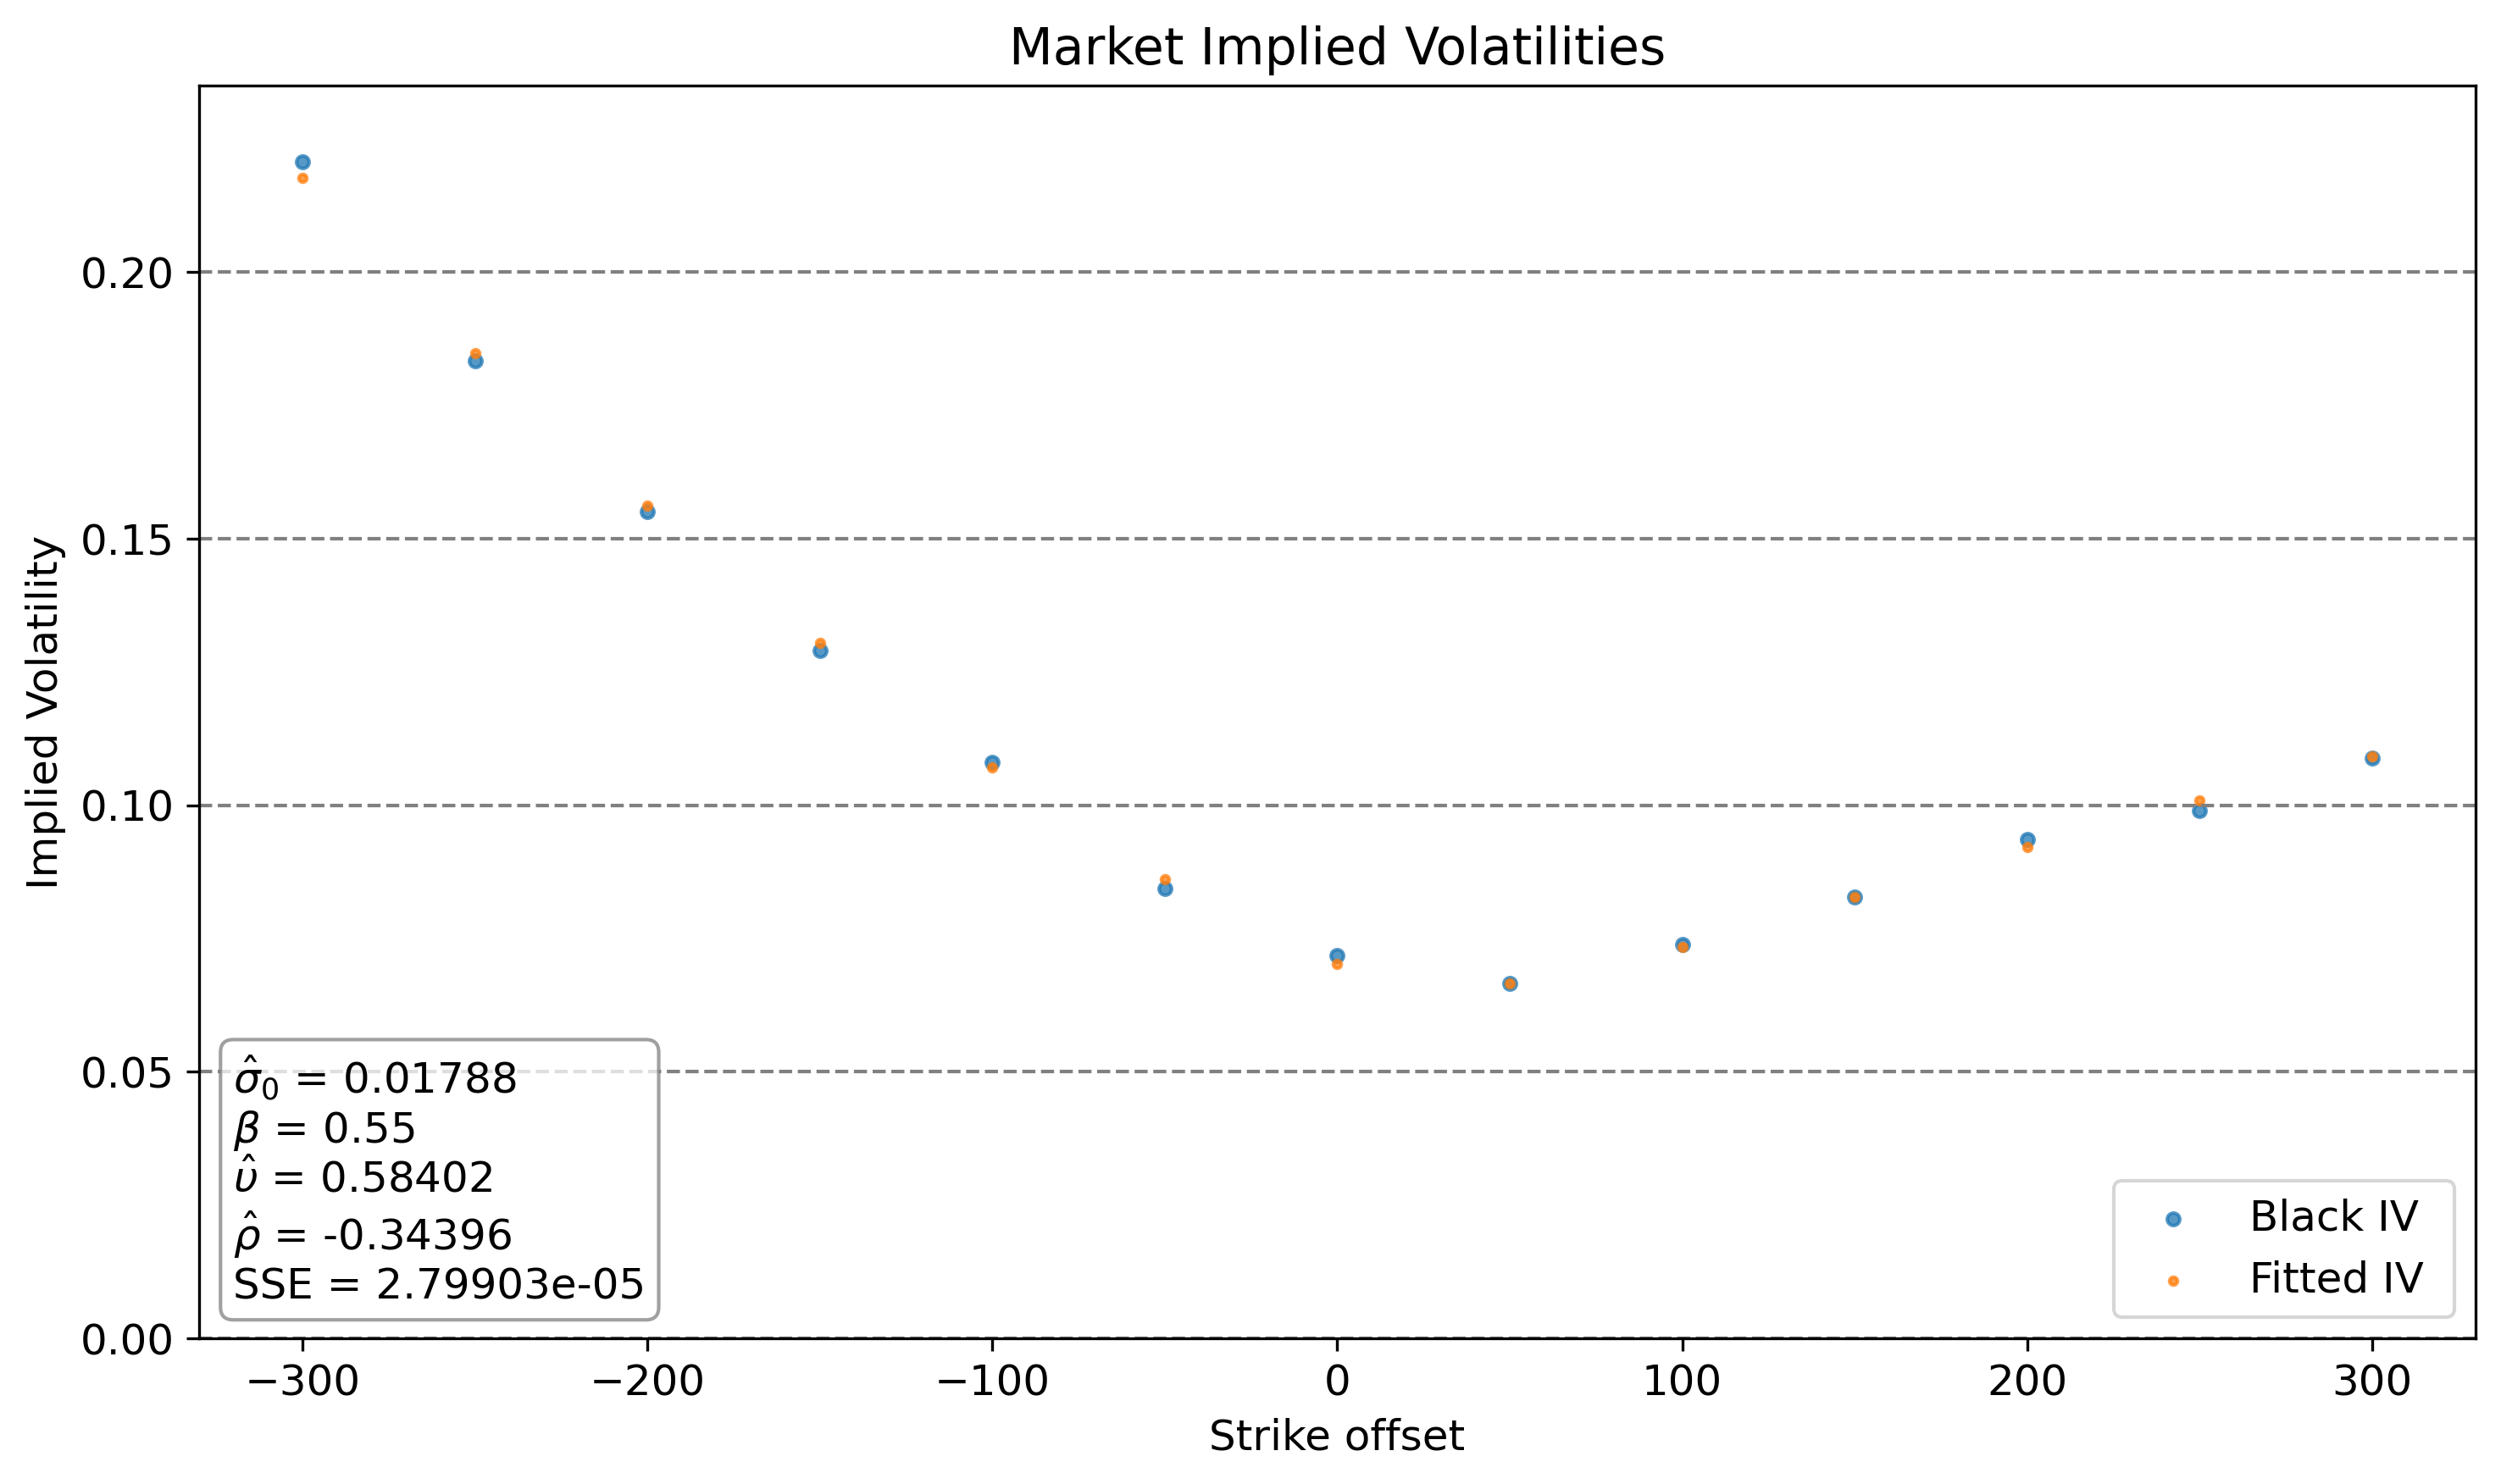

3Y7Y forward par swap rate: 0.055033694538703576, accrual factor: 4.783445969501005
Black implied volatility: 
[0.220675 0.18331  0.155103 0.129001 0.10812  0.084411 0.071866 0.066535
 0.073942 0.082751 0.093605 0.098971 0.108909]
3Y7Y forward par swap rate: 0.055033694538703576, accrual factor: 4.783445969501005
Closest swaption w. strike 0.06 is swaption w. strike +50 bps at strike 0.06003369453870357, price: 41.19304 bps
Bumping the inital rate:
Payer swaption value (bps): [15.55336514 16.05224903 16.56362095]
Receiver swaption value (bps): [32.00294486 31.42263996 30.85172209]
Value (bps): [47.55631    47.47488899 47.41534304]
PnL -1 bp: 0.8142100824081767 bps
PnL +1 bp: -0.5954594892840572 bps
Bumping the volatility:
Payer swaption value (bps): [13.72751511 16.05224903 18.57145549]
Receiver swaption value (bps): [27.95843731 31.42263996 35.03070756]
Value (bps): [41.68595243 47.47488899 53.60216305]
PnL sigma-0.01: -5.788936563506913 bps
PnL sigma+0.01: 6.1272740563760815 bps


In [5]:
interpolation_options = {"method":"nelson_siegel","transition": 'smooth'}
T_fit, R_fit, sse = fid.zcb_curve_fit(data_zcb,interpolation_options=interpolation_options)
T_inter = np.linspace(0, 30, 2*int(T_fit[-1])+1)
p_inter, R_inter, f_inter, T_inter = fid.zcb_curve_interpolate(T_inter=T_inter, T=T_fit, R=R_fit, interpolation_options=interpolation_options)

N_swaption = len(K_swaption_offset) 
y_exercise, y_maturity,idx_exercise = 3, 10, 6
# a
R_swaption, S_swaption = fid.swap_rate_from_zcb_prices(0, y_exercise, y_maturity, "annual", T_inter, p_inter)
idx_closest = 7
close_swaption = fid.black_swaption_price(iv_swaption_market[idx_closest], T_inter[idx_exercise], R_swaption+50/10000, S_swaption, R_swaption,type = "call")
# b
def fit_sabr_obj_no_beta(param, beta, sigma_market, K, T, R):
    sigma_0, upsilon, rho = param
    N = len(sigma_market)
    sse = 0
    for n in range(N):
        sigma_model = fid.sigma_sabr(K[n], T, R, sigma_0, beta, upsilon, rho, type="call")
        sse += (sigma_market[n] - sigma_model)**2
    return sse
K = np.zeros(N_swaption)
for i in range(N_swaption):
    K[i] = R_swaption + K_swaption_offset[i]/10000
beta = 0.55
param0 = 0.06, 0.45, -0.2
result = minimize(fit_sabr_obj_no_beta, param0, method = 'nelder-mead', args = (beta, iv_swaption_market, K, T_inter[idx_exercise], R_swaption) ,options={'xatol': 1e-10,'disp': False})
sigma0, upsilon, rho = result.x
iv_fit, price_fit = np.zeros(N_swaption), np.zeros(N_swaption)
for i in range(N_swaption):
    iv_fit[i] = fid.sigma_sabr(K[i],T_inter[idx_exercise],R_swaption,sigma0,beta,upsilon,rho,type = "call")
    price_fit[i] = fid.black_swaption_price(iv_fit[i],T_inter[idx_exercise],K[i],S_swaption,R_swaption,type = "call")
iv_plot = [{'label':'Black IV','x':K_swaption_offset,'y':iv_swaption_market, 's':50},
           {'label':'Fitted IV','x':K_swaption_offset,'y':iv_fit}]
text = {'$\hat{\sigma}_0$':sigma0,'$\\beta$':f'{beta:.2f}','$\hat{\\upsilon}$':upsilon,'$\hat{\\rho}$':rho, 'SSE':f'{result.fun:.5e}'}
plot.rates(iv_plot, title='Market Implied Volatilities', xlabel='Strike offset', ylabel='Implied Volatility', text=text)
print(f"3Y7Y forward par swap rate: {R_swaption}, accrual factor: {S_swaption}")
print(f'Black implied volatility: \n{iv_swaption_market}')
print(f"3Y7Y forward par swap rate: {R_swaption}, accrual factor: {S_swaption}")
print(f'Closest swaption w. strike 0.06 is swaption w. strike +50 bps at strike {R_swaption+50/10000}, price: {close_swaption*10000:.5f} bps')
# c 
F0_bump = [R_swaption - 1/10000, R_swaption, R_swaption + 1/10000]
sigma_bump = [sigma0 - 0.001, sigma0, sigma0 + 0.001]
idx_payer = 8
idx_reciever = 4
payer_value_rate_bump = np.zeros_like(F0_bump)
receiver_value_rate_bump = np.zeros_like(F0_bump)
value_rate_bump = np.zeros_like(F0_bump)
payer_value_sigma_bump = np.zeros_like(sigma_bump)
receiver_value_sigma_bump = np.zeros_like(sigma_bump)
value_sigma_bump = np.zeros_like(sigma_bump)
for i, F0 in enumerate(F0_bump):
    payer_value_rate_bump[i] = fid.black_swaption_price(iv_fit[idx_payer], T_inter[idx_exercise], K[idx_payer], S_swaption, F0, type = "call")
    receiver_value_rate_bump[i] = fid.black_swaption_price(iv_fit[idx_reciever], T_inter[idx_exercise], K[idx_reciever], S_swaption, F0, type = "put")
    value_rate_bump[i] = payer_value_rate_bump[i] + receiver_value_rate_bump[i]
print('Bumping the inital rate:')
print(f'Payer swaption value (bps): {payer_value_rate_bump*10000}')
print(f'Receiver swaption value (bps): {receiver_value_rate_bump*10000}')
print(f'Value (bps): {value_rate_bump*10000}')
print(f'PnL -1 bp: {(value_rate_bump[0] - value_rate_bump[1])*100000} bps\nPnL +1 bp: {(value_rate_bump[2] - value_rate_bump[1])*100000} bps')
for i, sigma in enumerate(sigma_bump):
    iv_sigma_payer = fid.sigma_sabr(K[idx_payer],T_inter[idx_exercise],R_swaption,sigma,beta,upsilon,rho)
    iv_sigma_receiver = fid.sigma_sabr(K[idx_reciever],T_inter[idx_exercise],R_swaption,sigma,beta,upsilon,rho)
    payer_value_sigma_bump[i] = fid.black_swaption_price(iv_sigma_payer, T_inter[idx_exercise], R_swaption+100/10000, S_swaption, R_swaption, type = "call")
    receiver_value_sigma_bump[i] = fid.black_swaption_price(iv_sigma_receiver, T_inter[idx_exercise], R_swaption-100/10000, S_swaption, R_swaption, type = "put")
    value_sigma_bump[i] = payer_value_sigma_bump[i] + receiver_value_sigma_bump[i]
print('Bumping the volatility:')
print(f'Payer swaption value (bps): {payer_value_sigma_bump*10000}')
print(f'Receiver swaption value (bps): {receiver_value_sigma_bump*10000}')
print(f'Value (bps): {value_sigma_bump*10000}')
print(f'PnL sigma-0.01: {(value_sigma_bump[0] - value_sigma_bump[1])*10000} bps\nPnL sigma+0.01: {(value_sigma_bump[2] - value_sigma_bump[1])*10000} bps')

#### a) 
From the Black implied volatilty we clearly see that there is a ’smirk’ in implied volatilities indicating that market prices are not equivalent to what would arise in a Black’s model. The pricing measure chosen by the market is not compatible with the 3Y7Y forward par swap rate following a log-normal distribution. The distribution implied by the measure chosen by the market has more fat tails and displays more left skewness than that of a log-normal random variable.

I find the ATMF forward rate as $0.05503$ which means the swaption closest to the desired strike of $0.06$ is the swaption +50 bps above the ATMF rate giving a price of $0.06003$ at a price of $41.19$ bps.

#### b)
When fitting I get the parameter values as $\hat{\sigma}_0=0.01788$, $\hat{\upsilon}=0.58402$, and $\hat{\rho}=-0.34296$ with a residual SSE of $2.80\cdot 10^{-5}$. As seen from the plotthe fitted implied volatility from the SABR model almost matches the market data.

#### c) 
A payer swaption gives the holder the right to enter into an interest rate swap as a fixed-rate payer, akin a call option on the par swap rate which gives the same right as they benefit when rates increase above the strike. Conversely, a receiver swaption gives the holder the right to become the fixed-rate receiver, functioning like a put option on the par swap rate, as they profit from falling rates. Calculating the value of this strangle posistion without any changes gives a value of $47.475$. The PnL for each case is as seen in the table below.
$$
\begin{array}{|c|c|}
\hline
\textbf{Scenario} & \textbf{PnL (bps)} \\
\hline
F_0-1 bp & 0.8142 \\
F_0+1 bp & -0.5955 \\
\sigma - 0.01 & -5.7889 \\
\sigma + 0.01 & 6.1273 \\
\hline
\end{array}
$$


# Problem 4

In [6]:
# a
print(f'10Y interest rate swap: fixed rate {R_swap:.5f}, accrual factor {S_swap:.5f}')
print(f"10Y interest rate cap: upfront cost : {price_cap*10000:.5f} bps, semi-annual premium: {alpha_caplet*price_cap*10000/S_cap:.5f} bps")
print(f'3Y7Y payer swaption: closest swaption to strike 0.06 is swaption w. strike +50 bps at strike {R_swaption+50/10000}, price: {close_swaption*10000:.5f} bps')

10Y interest rate swap: fixed rate 0.05539, accrual factor 7.49189
10Y interest rate cap: upfront cost : 120.06755 bps, semi-annual premium: 7.90387 bps
3Y7Y payer swaption: closest swaption to strike 0.06 is swaption w. strike +50 bps at strike 0.06003369453870357, price: 41.19304 bps


#### a)
The 10Y par swap rate is $0.05539$

The price of the 10Y interest cap with strike of $K=0.06$ is $120.06755$ bps upfront and semi-annual premium of $7.90387$ bps

The price of the 3Y7Y payer swaption with strike of $K=0.060034$ is $41.19$ bps

#### b)
**The 10Y interest rate swap:** The client would minimize his future payments if floating rate soars above $0.05539$ and stays high for entire duration as he then would be locked in at a lower rate. If the floating rate on the other hand drops to $0$ (or below), the net payment is $+0.05539$, maximizing total payments. 

**10Y Interest Rate Cap at $0.06$:** The client would minimize his future payments if rates drop to a lower level, e.g., 0 the resulting in the client only paying the upfront cost and premium. If rates hover around $6\%$ without exceeding it, no payoff is triggered and the client effectively pays $0.06$ plus the premium, which is the maximum total cost. 

**3Y7Y Payer Swaption at $0.060034$:** If in 3 years the floating rate is well above $0.060034$, exercising the swap yields negative net payments, minimizing total payments for this derivative. If the floating rate on the other hand is high in the imediate future and drops in the longer run ($>3$ years) such that the client is stuck paying a high interest the next 3 years and then lets the option expire and loses the $41.19$ bps premium, which is the maximum total cost.

#### c)
This depends on what one considers safe. If there by safe is reference least uncertainty about high rate then the 10Y interest swap fixing the rate and giving 0 uncertainty is the safest and the 3Y7Y payer swaption is the riskiest as it gives the most uncertainty about the high rates in the near future. The interest rate cap could also be considered the safest option as this eliminates any risk of rates above $0.06$ but still gives the client the opportunity to benefit from lower rates. 

#### d)
Although the swap eliminates future uncertainty at zero initial cost, it sacrifices the chance to benefit if rates stay below the swap rate. Options 2 and 3, however, allow for partial or conditional hedging that can reduce risk while maintaining some exposure to lower rates. Thus, they are good alternatives though they come at an upfront cost. It all depends in the risk profile of the client and his expectation of the future.

# Problem 5

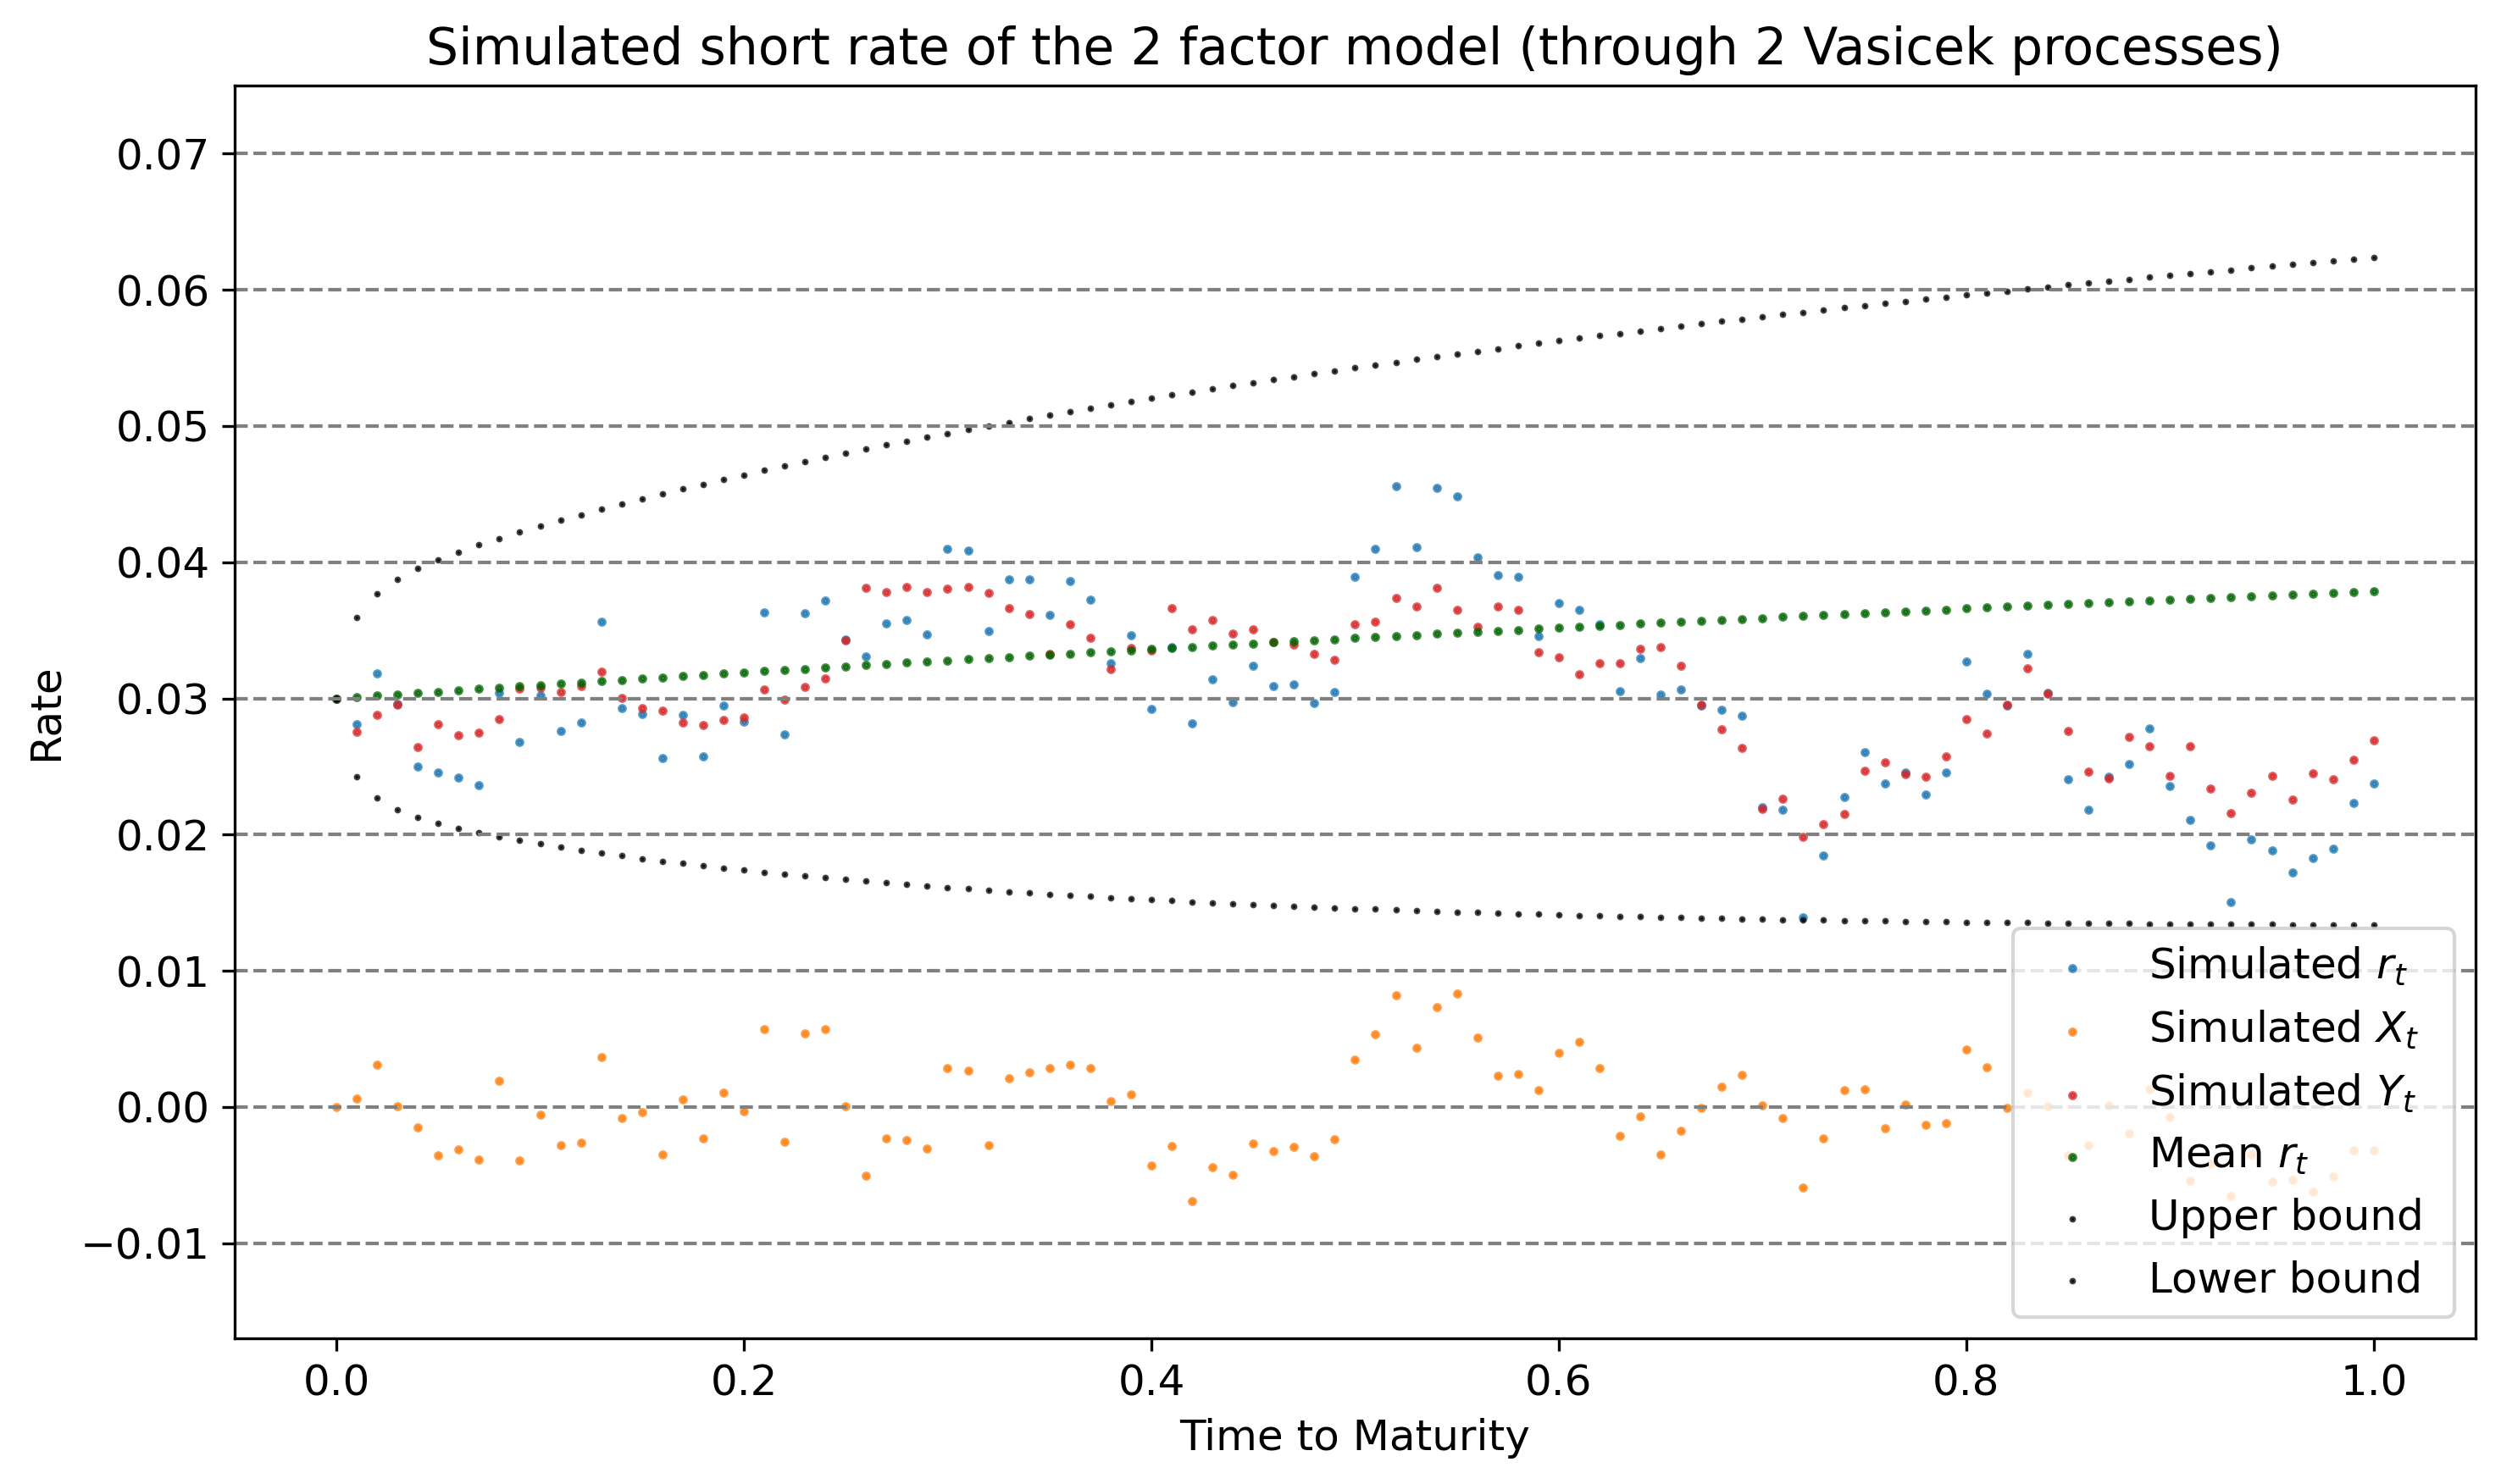

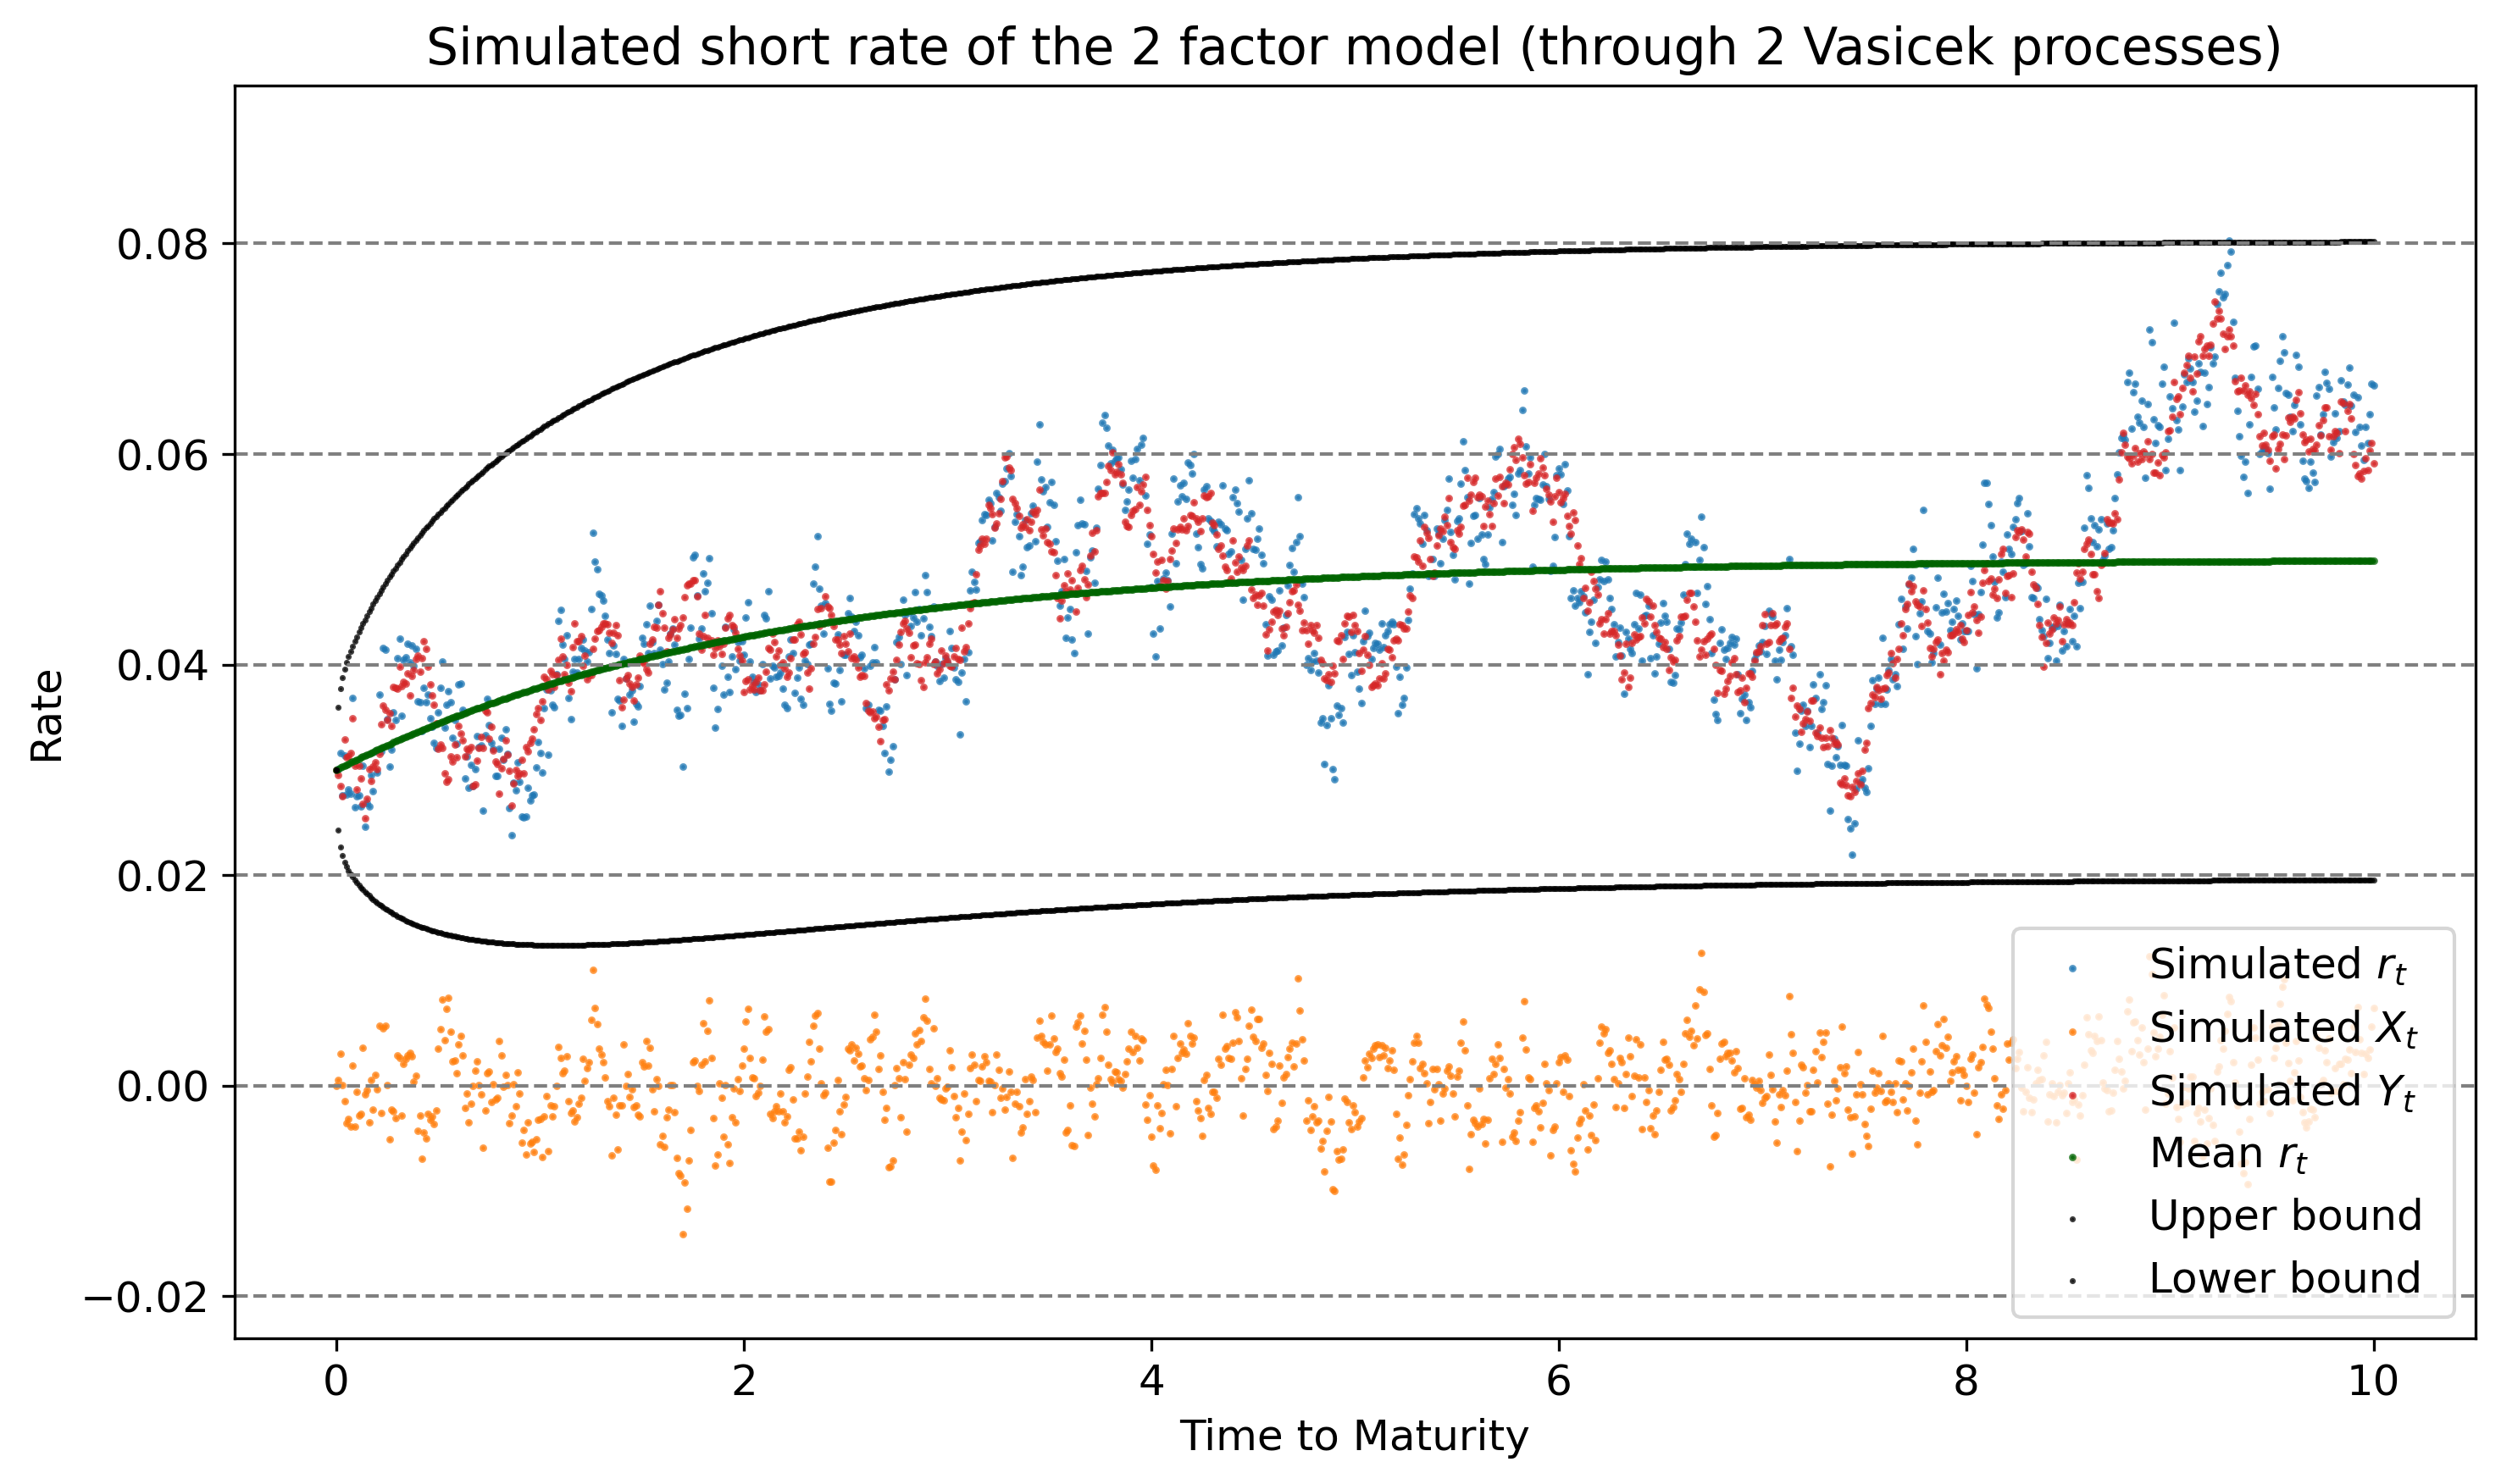

Upper bound at t=1: 0.06237, lower bound at t=1: 0.01337
Upper bound at t=10: 0.08017, lower bound at t=10: 0.01956


In [7]:
# c
def mean_2factor(x0, gamma, phi, y0, a, b, sigma, T):
    if T == np.inf:
        mean = b / a
    else:
        mean = x0 * np.exp(-gamma * T) + y0 * np.exp(-a * T) + (b / a) * (1 - np.exp(-a * T))
    return mean

def ci_2factor(x0, gamma, phi, y0, a, b, sigma, T, size_ci):
    if isinstance(T, (int, float, np.int32, np.int64, np.float64)):
        z = norm.ppf(size_ci + 0.5 * (1 - size_ci), 0, 1)
        if T < 1e-6:
            lb, ub = x0+y0, x0+y0
        elif T == np.inf:
            mean = b / a
            std = np.sqrt(sigma**2 / (2 * a))
            lb, ub = mean - z * std, mean + z * std
        else:
            mean = mean_2factor(x0, gamma, phi, y0, a, b, sigma, T)
            std = np.sqrt(phi**2 / (2 * gamma)*(1-np.exp(-2*gamma*T))+sigma**2 / (2 * a) * (1 - np.exp(-2 * a * T)))
            lb, ub = mean - z * std, mean + z * std
    elif isinstance(T, (tuple, list, np.ndarray)):
        N = len(T)
        lb, ub = np.zeros([N]), np.zeros([N])
        z = norm.ppf(size_ci + 0.5 * (1 - size_ci), 0, 1)
        for i in range(N):
            if T[i] < 1e-6:
                lb[i], ub[i] = x0+y0, x0+y0
            else:
                mean = mean_2factor(x0, gamma, phi, y0, a, b, sigma, T[i])
                std =np.sqrt(phi**2 / (2 * gamma)*(1-np.exp(-2*gamma*T[i]))+sigma**2 / (2 * a) * (1 - np.exp(-2 * a * T[i])))
                lb[i], ub[i] = mean - z * std, mean + z * std
    else:
        print(f"T is not of recognized type")
        lb, ub = False, False
    return lb, ub
x0, gamma, phi = 0, 32, 0.03
y0, a, b, sigma = 0.03, 0.5, 0.025, 0.015
N_simul, T_simul = 100, 1
t_simul = np.linspace(0, T_simul, N_simul+1)
ci_size = 0.95

np.random.seed(25)
x_simul = fid.simul_vasicek(x0, gamma, 0, phi, N_simul, T_simul, method='exact')
y_simul = fid.simul_vasicek(y0, a, b, sigma, N_simul, T_simul, method='exact')
r_simul = x_simul + y_simul
r_mean = np.zeros(N_simul+1)
for i, t in enumerate(t_simul):
    r_mean[i] = mean_2factor(x0, gamma, phi, y0, a, b, sigma, t)
r_lb, r_ub = ci_2factor(x0, gamma, phi, y0, a, b, sigma, t_simul, ci_size)
r_simul_plot = [{'label':'Simulated $r_t$','x':t_simul,'y':r_simul,'s':10},
                {'label':'Simulated $X_t$','x':t_simul,'y':x_simul,'s':10},
                {'label':'Simulated $Y_t$','x':t_simul,'y':y_simul,'s':10},
                {'label':'Mean $r_t$','x':t_simul,'y':r_mean,'s':10, 'color':'darkgreen'},
                {'label':f'Upper bound','x':t_simul,'y':r_ub,'s':3, 'color':'black'},
                {'label':f'Lower bound','x':t_simul,'y':r_lb,'s':3, 'color':'black'}]
plot.rates(r_simul_plot,title='Simulated short rate of the 2 factor model (through 2 Vasicek processes)')

N_simul10, T_simul10 = 1000, 10
t_simul10 = np.linspace(0, T_simul10, N_simul10+1)
np.random.seed(25)
x_simul10 = fid.simul_vasicek(x0, gamma, 0, phi, N_simul10, T_simul10, method='exact')
y_simul10 = fid.simul_vasicek(y0, a, b, sigma, N_simul10, T_simul10, method='exact')
r_simul10 = x_simul10 + y_simul10
r_mean10 = np.zeros(N_simul10+1)
for i, t in enumerate(t_simul10):
    r_mean10[i] = mean_2factor(x0, gamma, phi, y0, a, b, sigma, t)
r_lb10, r_ub10 = ci_2factor(x0, gamma, phi, y0, a, b, sigma, t_simul10, ci_size)
r_simul_plot10 = [{'label':'Simulated $r_t$','x':t_simul10,'y':r_simul10,'s':5},
                {'label':'Simulated $X_t$','x':t_simul10,'y':x_simul10,'s':5},
                {'label':'Simulated $Y_t$','x':t_simul10,'y':y_simul10,'s':5},
                {'label':'Mean $r_t$','x':t_simul10,'y':r_mean10,'s':5, 'color':'darkgreen'},
                {'label':f'Upper bound','x':t_simul10,'y':r_ub10,'s':2, 'color':'black'},
                {'label':f'Lower bound','x':t_simul10,'y':r_lb10,'s':2, 'color':'black'}]
plot.rates(r_simul_plot10,title='Simulated short rate of the 2 factor model (through 2 Vasicek processes)')
print(f'Upper bound at t=1: {r_ub[-1]:.5f}, lower bound at t=1: {r_lb[-1]:.5f}')
print(f'Upper bound at t=10: {r_ub10[-1]:.5f}, lower bound at t=10: {r_lb10[-1]:.5f}')

#### a)
I will find the solution of $r_T \mid x_0, y_0$ using the function $f(t,X,Y)$ were I observe that for $t=T$ I get:
$$
f(T,X_T,Y_T) = X_t + Y_t = r_T
$$
I start by defining the partial derivatives of $f$ as
$$
f_t = \frac{\partial f}{\partial t},\quad f_X = \frac{\partial f}{\partial X}, \quad f_Y = \frac{\partial f}{\partial Y}, \quad f_{XX} = \frac{\partial^2 f}{\partial X^2},\quad f_{YY} = \frac{\partial^2 f}{\partial Y^2},
$$
which I can compute as:
$$
\begin{split}
f_t &=\left(e^{-\gamma (T-t)}X + e^{-a (T-t)}Y\right)'  = \gamma e^{-\gamma(T-t)}X + ae^{-a(T-t)}Y \\
f_X &= e^{-\gamma (T-t)}, \\
f_Y &= e^{-a (T-t)}, \\
f_{XX} &= 0, \qquad f_{YY} = 0, \qquad f_{XY} = 0.
\end{split}
$$
Given the SDEs for $X_t$ and $Y_t$ it is clear that and $f$ is linear in $X$ and $Y$, the diffusion terms contribute simply via the first derivatives as the second order all are 2. Applying Ito's lemma gives
$$
\begin{split}
 d f(t,X_t,Y_t) &= f_t dt +  f_X dX_t + f_Y dY_t \\
&= [\gamma e^{-\gamma(T-t)}X_t + a e^{-a(T-t)}Y_t ]dt + e^{-\gamma(T-t)} (-\gamma X_tdt + \phi dW_t^{(1)}) + e^{-a(T-t)} ((b - a Y_t) dt + \sigma dW_t^{(2)}) \\
&=  e^{-a(T-t)} b dt +  e^{-\gamma(T-t)} \phi dW_t^{(1)} + e^{-a(T-t)} \sigma dW_t^{(2)}
\end{split}
$$
Now I integrate from $0$ to $T$ to get the short rate at time $T$ as
$$
\begin{split}
f\left(T, X_T, Y_T\right)  -  f\left(0, X_0, Y_0\right)
&= \int_0^T e^{-a (T-t)} b dt 
    + \int_0^T e^{-\gamma (T-t)} \phi dW_t^{(1)}
    + \int_0^T e^{-a (T-t)} \sigma dW_t^{(2)} \\
\implies
r_T 
&= e^{-\gamma T} x_0 + e^{-aT} y_0 
    + b\int_0^T  e^{-a (T-t)} dt
    + \int_0^T \phi e^{-\gamma (T-t)} dW_t^{(1)}
    + \int_0^T \sigma e^{-a (T-t)} dW_t^{(2)}
\end{split}
$$
where I have used that $f(T,X_T,Y_T) = r_T$ and $f(0,X_0,Y_0) = e^{-\gamma T} x_0  +  e^{-aT} y_0$. The only deterministic integral is $b\int_0^T  e^{-a (T-t)} dt$ which I can compute using substitution as
$$
b \int_0^T e^{-a (T-t)} dt = \frac{b}{a}\left(1 - e^{-a T}\right)
$$

Thus I get 
$$
r_T \mid x_0, y_0 = x_0 e^{-\gamma T} + y_0 e^{-a T}+ \frac{b}{a} \left(1 - e^{-a T}\right) + \int_0^T \phi e^{-\gamma (T-t)} dW_t^{(1)} + \int_0^T \sigma e^{-a (T-t)} dW_t^{(2)}.
$$

#### b)
We see that $r_T$ is constist of a deterministic part and  a linear combination of two independent integrals (one for $X$, one for $Y$). Each of the integrals are Gaussian with mean 0 because $W_t^{(1)}$ and $W_t^{(2)}$ are independent Brownian motions; hence $r_T$ must be Gaussian as well.

The stochastice integrals have mean zero and I can calculate the expectation of the square of the short rate as
$$
\begin{split}
\mathbb{E}[r_T]
&= x_0 e^{-\gamma T} + y_0 e^{-a T}  + \frac{b}{a} \left(1 - e^{-a T}\right) + \underbrace{\mathbb{E}\left[\int_0^T \phi e^{-\gamma (T-t)} dW_t^{(1)}\right]}_{0} + \underbrace{\mathbb{E}\left[\int_0^T \sigma e^{-a (T-t)} dW_t^{(2)}\right]}_{0} \\
&= x_0 e^{-\gamma T}  + y_0 e^{-a T} + \frac{b}{a} \left(1 - e^{-a T}\right)
\end{split}
$$

Moving on to the variance I have
$$
r_T  = \underbrace{ \left[x_0 e^{-\gamma T} + y_0 e^{-a T} + \tfrac{b}{a}(1 - e^{-aT}) \right]}_{\text{Deterministic}} + \underbrace{\int_0^T \phi e^{-\gamma (T-t)} dW_t^{(1)}}_{I_1} + \underbrace{\int_0^T \sigma e^{-a (T-t)} dW_t^{(2)}}_{I_2},
$$
and the two Brownian motions $W^{(1)}$ and $W^{(2)}$ are independent, I get
$$
\mathrm{Var}[r_T]  = \mathrm{Var}[I_1] + \mathrm{Var}[I_2].
$$
I can calculate the variance of the two integrals as
$$
\mathrm{Var}[I_1]
= \phi^2 \int_0^T e^{-2 \gamma (T-t)} dt
= \frac{\phi^2}{2 \gamma}  \left(1 - e^{-2 \gamma T} \right).
$$
$$
\mathrm{Var}[I_2]
= \sigma^2 \int_0^T e^{-2 a (T-t)} dt
= \frac{\sigma^2}{2 a}  \left(1 - e^{-2 a T} \right).
$$
Summing the two variances gives
$$
V(T) = \frac{\phi^2}{2 \gamma}  \left[ 1 - e^{-2 \gamma T} \right] +  \frac{\sigma^2}{2 a}  \left[ 1 - e^{-2 a T} \right]
$$
Hence I have $r_T \mid (x_0,y_0) \sim \mathcal{N}(M(T;x_0,y_0),V(T))$. Setting $T\to \infty$ I get the stationary distribution of the short rate as
$$
\lim_{T\to\infty} M(T;x_0,y_0)
= 0 + 0 + \frac{b}{a}
= \frac{b}{a}.
$$
For the variance I get
$$
\lim_{T\to\infty} V(T)
= \frac{\phi^2}{2 \gamma}(1-0) + \frac{\sigma^2}{2 a}(1-0) = \frac{\phi^2}{2 \gamma} + \frac{\sigma^2}{2 a}
$$
Therefore,
$$
r_\infty   \sim   \mathcal{N}\! \left( \frac{b}{a},    \frac{\phi^2}{2 \gamma}   +   \frac{\sigma^2}{2 a} \right).
$$

#### c)
The simulated trajectories for $X_t$, $Y_t$ and $r_t$ are seen in the plot for $t$ goint to 1 and 10. In the plot for $t$ going to 10 we clearly see a mean reversion towards the stationary distribution. I get the following upper and lower bounds for the short rate at $t=1$ and $t=10$:
$$
\begin{array}{|c|c|c|}
\hline
\textbf{Time (t)} & \textbf{Upper Bound} & \textbf{Lower Bound} \\
\hline
t=1 & 0.06237 & 0.01337 \\
t=10 & 0.08017 & 0.01956 \\
\hline
\end{array}
$$


#### d)
The mean reverting parameter in the standard Vasicek is $a$ which in our case is $\gamma=32$ and $a=0.5$ for $X_t$ and $Y_t$ respectively. As $\gamma>a$ $X_t$ has the greatest mean reversion, furthermore it start at its mean of $\frac{0}{\gamma} = 0$ and $Y_t$ starts below its mean of  $\frac{b}{a} = 0.05$. Hence not only does $X_t$ mean revert faster, it also starts at its mean and hence has mean reverted.

The volatility parameters for $X_t$ and $Y_t$ are $\phi=0.03$ and $\sigma=0.015$ respectively; hence the variability is much greater in $X_t$ and also has a higher impact on $r_t$ as it defacto serves as an additional variation given it just fluctuates around 0.

Give the mean of $X_t$ is 0 the mean of $r_t$ in the stationary distribution must be equivalent to that of $Y_t$ which is $\frac{b}{a} = 0.05$. However, it will fluctuate around this mean with a higher variance than $Y_t$ due to the additional volatility from $X_t$.